In [1]:
%load_ext autoreload
%autoreload 2

# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json

from datetime import datetime

from utils import get_data, Config, clean_url, make_clickable, add_columns

In [2]:
# Load all data (except unknown/manual testing)
# Parsing + Basic 5x+ each, and reruns (such that all tests have 5+ results)
# Ubuntu 22.04, Android 11, MacOS 14.3.1, iPadOS 17.3.1
# All runs performed between 2024-03-07 and 2024-05-14

# New browsers: Ubuntu 22.04, MacOS 15.2
# All runs performed between 2024-12-13 and 2024-12-20
initial_data = """
SELECT "Result".*, 
"Response".raw_header, "Response".status_code, "Response".label, "Response".resp_type,
"Browser".name, "Browser".version, "Browser".headless_mode, "Browser".os, "Browser".automation_mode, "Browser".add_info
FROM "Result"
JOIN "Response" ON "Result".response_id = "Response".id JOIN "Browser" ON "Result".browser_id = "Browser".id
WHERE "Browser".name != 'Unknown' AND "Response".resp_type !=  'debug';
"""
df = get_data(Config(), initial_data)
df = add_columns(df)

Connecting to the PostgreSQL database...
Connection successful


In [3]:
df["raw_header"] = df["raw_header"].apply(bytes).apply(lambda x: json.loads(x.decode("utf-8"))).astype(str)
def create_test_id(row):
    return f'{row["test_name"]}_{row["relation_info"]}_{row["org_scheme"]}_{row["org_host"]}_{row["resp_scheme"]}_{row["resp_host"]}_{row["response_id"]}_{row["resp_type"]}'

df["browser_id"] = df["browser_id"].astype("category")
# Takes a while (1000s+) (might be faster to already do it with postgres but not too important)
df["test_id"] = df.apply(create_test_id, axis=1)
df["test_id"] = df["test_id"].astype("category")

In [4]:
responses = """
SELECT * from "Response";
"""
responses = get_data(Config(), responses)

Connecting to the PostgreSQL database...
Connection successful


# Overview
- Collected between 885730 and 1558656 results for 12 browsers (original)
- Collected between 885730 and 892980 results for 4 browsers (update december)

In [5]:
# Only main and finished browsers
# Remove other browsers/os
# iOS unfinished browsers: old chrome (26), old brave (27), opera (28), safari (30), brave (54)
# edge (same as chrome, only desktop): 44
# duckduckgo (very old webview version): 66
# opera (same as chrome, only mobile: 63
# chrome (HSTS testing only): 70
# brave (android shields disabled): 65
# chrome (test): 71

df = df.loc[~df["browser_id"].isin([30, 27, 26, 54, 28, 66, 63, 44, 70, 65, 71])]

In [6]:
# Do not analyze OAC as it is only supported in Chromium + noisy 
df = df.loc[~df["test_name"].str.startswith("oac")]

In [7]:
# Both basic + parsing mode
# Each test should have results 5+ times (such that we can better reason about noise + majority voting makes sense)
df.groupby(["automation_mode", "browser_id", "name", "version", "os", "headless_mode"], observed=True)["id"].count().sort_values(ascending=False).to_frame().reset_index()

,automation_mode,browser_id,name,version,os,headless_mode,id
0,intent,68,brave,1.62.165_shield,Android 11,real,1558656
1,intent,64,firefox_beta,123.0b9,Android 11,real,968298
2,intent,62,chrome,121.0.6167.180,Android 11,real,921540
3,selenium,51,safari,17.3.1,macOS 14.3.1,real,907865
4,selenium,74,chrome,131,Ubuntu 22.04,headless-new,892980
5,intent,60,chrome,122.0.6261.89,iPadOS 17.3.1,real,890198
6,selenium,47,chrome,122,Ubuntu 22.04,headless-new,886198
7,selenium,45,brave,v1.62.156 (121.0.6167.139),Ubuntu 22.04,headless-new,885810
8,selenium,61,firefox,123,Ubuntu 22.04,headless,885746
9,selenium,49,firefox,121,Ubuntu 22.04,headless,885746


In [8]:
len(df)

14978833

In [9]:
# Number of Test URLs visited (all, including timeouts and co.)
df.groupby(["browser"])["full_url"].agg(["count", "nunique"])

,count,nunique
browser,,
brave Android 11 1.62.165_shield intent real,1558656,195549
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,885810,23083
brave Ubuntu 22.04 v1.73.101 (Chromium 131.0.6778.139) selenium headless-new,885730,22056
chrome Android 11 121.0.6167.180 intent real,921540,123661
chrome Ubuntu 22.04 120 selenium headless-new,885730,22130
chrome Ubuntu 22.04 121 selenium headless-new,885730,22139
chrome Ubuntu 22.04 122 selenium headless-new,886198,25918
chrome Ubuntu 22.04 131 selenium headless-new,892980,26206
chrome iPadOS 17.3.1 122.0.6261.89 intent real,890198,27256


## Error + Timeout Analysis
- Small number of random timeouts in both parsing/basic mode
- Very small number of not-run in Opera and Brave Android and MacOS Safari (all HSTS)
- Iterativily designed (we had more issues in the past):
  - We use higher timeouts for certain tests that timed out more often in debug runs
  - We use higher timeouts for Android
  - We use higher timeouts for the repeat runs

In [10]:
# Timeout (2), Fail (1), Not-run (3)
display(df.groupby(["browser"])["test_status"].value_counts().to_frame().unstack().T)

display(df["test_status"].value_counts())


browser            brave Android 11 1.62.165_shield intent real  \
      test_status                                                 
count 0                                               1558651.0   
      2                                                     5.0   
      3                                                     NaN   

browser            brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new  \
      test_status                                                                        
count 0                                                     885802.0                     
      2                                                          8.0                     
      3                                                          NaN                     

browser            brave Ubuntu 22.04 v1.73.101 (Chromium 131.0.6778.139) selenium headless-new  \
      test_status                                                                                 
count 0                                                     885730.0                              
      2                                                          NaN                              
      3                                                          NaN                              

browser            chrome Android 11 121.0.6167.180 intent real  \
      test_status                                                 
count 0                                                921539.0   
      2                                                     1.0   
      3                                                     NaN   

browser            chrome Ubuntu 22.04 120 selenium headless-new  \
      test_status                                                  
count 0                                                 885730.0   
      2                                                      NaN   
      3                                                      NaN   

browser            chrome Ubuntu 22.04 121 selenium headless-new  \
      test_status                                                  
count 0                                                 885730.0   
      2                                                      NaN   
      3                                                      NaN   

browser            chrome Ubuntu 22.04 122 selenium headless-new  \
      test_status                                                  
count 0                                                 886181.0   
      2                                                     17.0   
      3                                                      NaN   

browser            chrome Ubuntu 22.04 131 selenium headless-new  \
      test_status                                                  
count 0                                                 892980.0   
      2                                                      NaN   
      3                                                      NaN   

browser            chrome iPadOS 17.3.1 122.0.6261.89 intent real  \
      test_status                                                   
count 0                                                  890197.0   
      2                                                       1.0   
      3                                                       NaN   

browser            firefox Ubuntu 22.04 121 selenium headless  \
      test_status                                               
count 0                                              885745.0   
      2                                                   1.0   
      3                                                   NaN   

browser            firefox Ubuntu 22.04 122 selenium headless  \
      test_status                                               
count 0                                              885730.0   
      2                                                   NaN   
      3                                                   NaN   

browser            

test_status
0    14978671
2         134
3          28
Name: count, dtype: int64

In [11]:
# Teststatus == 2 (timeout)

# Rare timeouts in some browsers
display(df[df["test_status"] == 2]["browser"].value_counts().to_frame())

with pd.option_context("display.max_rows", 80):
    display(df.loc[(df["test_status"] == 2)].groupby(["resp_type", "status_code", "test_name"])["browser"].value_counts().to_frame().sort_values(by="count", ascending=False))

,count
browser,
firefox_beta Android 11 123.0b9 intent real,65
safari macOS 14.3.1 17.3.1 selenium real,31
chrome Ubuntu 22.04 122 selenium headless-new,17
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,8
brave Android 11 1.62.165_shield intent real,5
safari macOS 15.2 18.2 selenium real,4
firefox Ubuntu 22.04 123 selenium headless,1
chrome iPadOS 17.3.1 122.0.6261.89 intent real,1
firefox Ubuntu 22.04 121 selenium headless,1


count
resp_type status_code test_name             browser                                                  
basic     200         referrer_iframe       firefox_beta Android 11 123.0b9 intent real            42
parsing   200         framing_iframe        safari macOS 14.3.1 17.3.1 selenium real               20
                      accesswindow_direct   firefox_beta Android 11 123.0b9 intent real            14
                      upgradeHSTS_subdomain safari macOS 14.3.1 17.3.1 selenium real                6
basic     200         referrer_iframe       brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...      6
                      fullscreen_iframe     chrome Ubuntu 22.04 122 selenium headless-new           5
parsing   200         framing_iframe        firefox_beta Android 11 123.0b9 intent real             5
                      fullscreen_iframe     brave Android 11 1.62.165_shield intent real            5
basic     200         framing_embed         chrome Ubuntu 22.04 122 selenium headless-new           4
                      framing_object        chrome Ubuntu 22.04 122 selenium headless-new           4
          302         referrer_iframe       firefox_beta Android 11 123.0b9 intent real             4
parsing   200         upgradeHSTS_direct    safari macOS 14.3.1 17.3.1 selenium real                4
basic     200         referrer_iframe       safari macOS 15.2 18.2 selenium real                    3
                      framing_iframe        chrome Ubuntu 22.04 122 selenium headless-new           3
                      fullscreen_iframe     brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...      2
          302         framing_embed         chrome Android 11 121.0.6167.180 intent real            1
          200         referrer_iframe       chrome Ubuntu 22.04 122 selenium headless-new           1
                                            firefox Ubuntu 22.04 121 selenium headless              1
                                            firefox Ubuntu 22.04 123 selenium headless              1
parsing   200         accesswindow_direct   safari macOS 14.3.1 17.3.1 selenium real                1
                                            safari macOS 15.2 18.2 selenium real                    1
                      upgradeHSTS_subdomain chrome iPadOS 17.3.1 122.0.6261.89 intent real          1

In [12]:
# Teststatus == 3 (not-run)

display(df[df["test_status"] == 3]["browser"].value_counts().to_frame())

display(df.loc[(df["test_status"] == 3)].groupby(["resp_type", "status_code", "test_name"])["browser"].value_counts().to_frame().sort_values(by="count", ascending=False))

,count
browser,
safari macOS 14.3.1 17.3.1 selenium real,28


count
resp_type status_code test_name             browser                                        
parsing   200         upgradeHSTS_subdomain safari macOS 14.3.1 17.3.1 selenium real     21
                      upgradeHSTS_direct    safari macOS 14.3.1 17.3.1 selenium real      7

## General Test Statistics
- 9784 basic tests
- 165376 parsing tests
- We collected between 5 and 54 outcomes for each test
- If we have more than 5 outcomes this is either due to a repeat run that included tests that already had all 5 results 
- Or in Android where our intent-based test infrastructure cannot close tabs and sometimes they are executed again

In [13]:
df["file_name"] = df["clean_url"].apply(lambda x: x.split("tests/")[1].split(".")[0])

In [14]:
# Number of test_ids for each "group": resp_type, test_name, relation_info
df.groupby(["resp_type", "file_name", "test_name", "relation_info"])["test_id"].nunique().to_frame().unstack(0)

test_id  \
resp_type                                                               basic   
file_name                test_name                     relation_info            
fetch-cors               fetch_GET                     credentials       96.0   
                                                       custom_headers    96.0   
                                                       simple            96.0   
                         fetch_TEST                    custom_method     96.0   
framing                  framing_embed                 direct           560.0   
                                                       nested           560.0   
                                                       sandbox          560.0   
                         framing_iframe                direct           560.0   
                                                       nested           560.0   
                                                       sandbox          560.0   
                         framing_object                direct           560.0   
                                                       nested           560.0   
                                                       sandbox          560.0   
fullscreen-api-pp        fullscreen_iframe             child            384.0   
                                                       child_allow      384.0   
                                                       child_sandbox    384.0   
                                                       direct           384.0   
perfAPI-tao              perfAPI_img                   direct           208.0   
referrer-access-rp       referrer_iframe               iframe           256.0   
                                                       window.open      256.0   
script-execution-csp     script_execution_iframe       direct           272.0   
                                                       sandbox          272.0   
script-execution-xcto    sniffing_script               direct           208.0   
subresource-loading-coep subresourceloadingCOEP_img    direct           176.0   
                                                       sandbox          176.0   
subresource-loading-corp subresourceloadingCORP_img    direct           176.0   
                                                       nested           176.0   
                                                       sandbox          176.0   
                         subresourceloadingCORP_object direct           176.0   
subresource-loading-csp  imgloading_iframe             direct           272.0   
upgrade-hsts             upgradeHSTS_direct            direct            28.0   
                         upgradeHSTS_subdomain         subdomain         28.0   
window-references-coop   accesswindow_direct           direct           176.0   

                                                                             \
resp_type                                                             debug   
file_name                test_name                     relation_info          
fetch-cors               fetch_GET                     credentials     32.0   
                                                       custom_headers  32.0   
                                                       simple          32.0   
                         fetch_TEST                    custom_method   32.0   
framing                  framing_embed                 direct          96.0   
                                                       nested          96.0   
                                                       sandbox         96.0   
                         framing_iframe                direct          96.0   
                                                       nested          96.0   
                                                       sandbox         96.0   
                         framing_object                direct          96.0   
                                               

In [15]:
all_test_functions = df[["test_name", "relation_info"]].drop_duplicates()
print(len(all_test_functions))
display(all_test_functions)

35


,test_name,relation_info
0,fetch_TEST,custom_method
1,fetch_GET,custom_headers
2,fetch_GET,credentials
3,fetch_GET,simple
50,fullscreen_iframe,child_allow
51,fullscreen_iframe,direct
57,accesswindow_direct,direct
79,framing_iframe,direct
80,framing_iframe,nested
205,subresourceloadingCOEP_img,direct


In [16]:
display(df.groupby(["resp_type"])["response_id"].nunique())

display(df.groupby(["resp_type", "label"])["response_id"].nunique())

resp_type
basic        188
debug         28
parsing    43416
Name: response_id, dtype: int64

resp_type  label     
basic      COEP            11
           COOP            11
           CORP            11
           CORS             6
           CSP-FA          17
           CSP-IMG         17
           CSP-SCRIPT      17
           CSPvsXFO         7
           HSTS            14
           PP              24
           RP              16
           TAO             13
           XCTO            13
           XFO             11
debug      COEP             2
           COOP             2
           CORP             2
           CORS             2
           CSP-FA           2
           CSP-IMG          2
           CSP-SCRIPT       2
           CSPvsXFO         2
           HSTS             2
           PP               2
           RP               2
           TAO              2
           XCTO             2
           XFO              2
parsing    COEP          2637
           COOP          2656
           CORP          3357
           CORS-ACAC      864
           CORS-AC

In [17]:
4596+1440+2744 , 864+1577+1576+2465+1577

(8780, 8059)

In [18]:
8780*2

17560

In [19]:
8059*2

16118

In [20]:
# 175 basic responses (/13 label groups) * 32 test functions * 16 origin relations * 4
(188/13)*33*16

7635.692307692308

In [21]:
len(df.loc[df["resp_type"] == "parsing"][["test_name","relation_info"]].drop_duplicates())

20

In [22]:
43416/17 * 17 * 4

173664.0

In [23]:
# Number of test_ids per browser
# Should be 9992 and 167154
df.loc[df["test_status"] == 0].groupby(["resp_type", "browser"])["test_id"].nunique()

resp_type  browser                                                                     
basic      brave Android 11 1.62.165_shield intent real                                      9992
           brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new               9992
           brave Ubuntu 22.04 v1.73.101 (Chromium 131.0.6778.139) selenium headless-new      9992
           chrome Android 11 121.0.6167.180 intent real                                      9992
           chrome Ubuntu 22.04 120 selenium headless-new                                     9992
           chrome Ubuntu 22.04 121 selenium headless-new                                     9992
           chrome Ubuntu 22.04 122 selenium headless-new                                     9992
           chrome Ubuntu 22.04 131 selenium headless-new                                     9992
           chrome iPadOS 17.3.1 122.0.6261.89 intent real                                    9992
           firefox Ubuntu 22.0

In [25]:
df = df.loc[df["resp_type"] != 'debug']

In [26]:
# Which tests have how many outcomes?

grouped = df.loc[df["test_status"] == 0].groupby(["test_name", "org_scheme", "org_host", "resp_scheme", "resp_host", "relation_info", "response_id", "browser", "resp_type"])['outcome_str'].count().reset_index()

with pd.option_context("display.max_rows", 256):
    display(grouped.groupby("browser")["outcome_str"].agg(["mean", "min", "max"]).T)
    res = grouped.groupby(["browser", "resp_type", "test_name"])["outcome_str"].agg(["mean", "min", "max", "count", "sum"]).sort_values(by="mean", ascending=False)
    display(res.loc[res["mean"] > 0].head(10))
    display(res.loc[res["mean"] > 0].tail(10))


browser,brave Android 11 1.62.165_shield intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,brave Ubuntu 22.04 v1.73.101 (Chromium 131.0.6778.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new,chrome Ubuntu 22.04 122 selenium headless-new,chrome Ubuntu 22.04 131 selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless,firefox Ubuntu 22.04 123 selenium headless,firefox Ubuntu 22.04 133 selenium headless,firefox_beta Android 11 123.0b9 intent real,safari macOS 14.3.1 17.3.1 selenium real,safari macOS 15.2 18.2 selenium real
mean,8.79868,5.000406,5.0,5.202144,5.0,5.0,5.002546,5.040927,5.025216,5.000085,5.0,5.000085,5.000023,5.465734,5.12462,4.880731
min,5.00000,5.000000,5.0,5.000000,5.0,5.0,5.000000,5.000000,5.000000,5.000000,5.0,5.000000,5.000000,5.000000,5.00000,2.000000
max,22.00000,6.000000,5.0,52.000000,5.0,5.0,6.000000,6.000000,16.000000,6.000000,5.0,6.000000,6.000000,54.000000,10.00000,7.000000


mean  \
browser                                      resp_type test_name                               
chrome Android 11 121.0.6167.180 intent real parsing   sniffing_script             13.415073   
firefox_beta Android 11 123.0b9 intent real  parsing   accesswindow_direct         12.941453   
brave Android 11 1.62.165_shield intent real basic     upgradeHSTS_direct          10.642857   
                                                       upgradeHSTS_subdomain       10.642857   
firefox_beta Android 11 123.0b9 intent real  basic     sniffing_script             10.346154   
brave Android 11 1.62.165_shield intent real parsing   subresourceloadingCOEP_img   9.405954   
firefox_beta Android 11 123.0b9 intent real  parsing   imgloading_iframe            9.383395   
brave Android 11 1.62.165_shield intent real parsing   fetch_GET                    9.276275   
                                                       fetch_TEST                   9.276275   
                                                       perfAPI_img                  9.219863   

                                                                                   min  \
browser                                      resp_type test_name                         
chrome Android 11 121.0.6167.180 intent real parsing   sniffing_script               5   
firefox_beta Android 11 123.0b9 intent real  parsing   accesswindow_direct           5   
brave Android 11 1.62.165_shield intent real basic     upgradeHSTS_direct            5   
                                                       upgradeHSTS_subdomain         5   
firefox_beta Android 11 123.0b9 intent real  basic     sniffing_script               5   
brave Android 11 1.62.165_shield intent real parsing   subresourceloadingCOEP_img    5   
firefox_beta Android 11 123.0b9 intent real  parsing   imgloading_iframe             5   
brave Android 11 1.62.165_shield intent real parsing   fetch_GET                     5   
                                                       fetch_TEST                    5   
                                                       perfAPI_img                   6   

                                                                                   max  \
browser                                      resp_type test_name                         
chrome Android 11 121.0.6167.180 intent real parsing   sniffing_script              52   
firefox_beta Android 11 123.0b9 intent real  parsing   accesswindow_direct          54   
brave Android 11 1.62.165_shield intent real basic     upgradeHSTS_direct           17   
                                                       upgradeHSTS_subdomain        17   
firefox_beta Android 11 123.0b9 intent real  basic     sniffing_script              17   
brave Android 11 1.62.165_shield intent real parsing   subresourceloadingCOEP_img   20   
firefox_beta Android 11 123.0b9 intent real  parsing   imgloading_iframe            54   
brave Android 11 1.62.165_shield intent real parsing   fetch_GET                    22   
                                                       fetch_TEST                   22   
                                                       perfAPI_img                  18   

                                                                                   count  \
browser                                      resp_type test_name                           
chrome Android 11 121.0.6167.180 intent real parsing   sniffing_script              1778   
firefox_beta Android 11 123.0b9 intent real  parsing   accesswindow_direct          5312   
brave Android 11 1.62.165_shield intent real basic     upgradeHSTS_direct             28   
                                                       upgradeHSTS_subdomain          28   
firefox_beta Android 11 123.0b9 intent real  basic     sniffing_script               208   
brave Android 11 1.62.165_shield intent real parsing   subresourceloadingCOEP_img   5274   
firefox_beta Android 11 123.0b9 inten

mean  \
browser                              resp_type test_name                              
safari macOS 15.2 18.2 selenium real parsing   fetch_GET                   4.998449   
                                               fetch_TEST                  4.998449   
                                               perfAPI_img                 4.990631   
                                               accesswindow_direct         4.780120   
                                               fullscreen_iframe           4.636211   
                                               framing_iframe              4.604613   
                                               subresourceloadingCOEP_img  4.562002   
                                               subresourceloadingCORP_img  4.505511   
                                               imgloading_iframe           4.503506   
                                               sniffing_script             4.497188   

                                                                           min  \
browser                              resp_type test_name                         
safari macOS 15.2 18.2 selenium real parsing   fetch_GET                     4   
                                               fetch_TEST                    4   
                                               perfAPI_img                   4   
                                               accesswindow_direct           3   
                                               fullscreen_iframe             4   
                                               framing_iframe                2   
                                               subresourceloadingCOEP_img    4   
                                               subresourceloadingCORP_img    4   
                                               imgloading_iframe             4   
                                               sniffing_script               4   

                                                                           max  \
browser                              resp_type test_name                         
safari macOS 15.2 18.2 selenium real parsing   fetch_GET                     5   
                                               fetch_TEST                    5   
                                               perfAPI_img                   5   
                                               accesswindow_direct           5   
                                               fullscreen_iframe             5   
                                               framing_iframe                5   
                                               subresourceloadingCOEP_img    5   
                                               subresourceloadingCORP_img    5   
                                               imgloading_iframe             5   
                                               sniffing_script               5   

                                                                           count  \
browser                              resp_type test_name                           
safari macOS 15.2 18.2 selenium real parsing   fetch_GET                   48354   
                                               fetch_TEST                  16118   
                                               perfAPI_img                  3202   
                                               accesswindow_direct          5312   
                                               fullscreen_iframe           15520   
                                               framing_iframe              35120   
                                               subresourceloadingCOEP_img   5274   
                                               subresourceloadingCORP_img   6714   
                                               imgloading_iframe            5420   
                                               sniffing_script              1778   

                                                       

## Stability
- How many tests have more than one result for the 5+ repetitions in a browser?

### General
- Basic:
    - total of 264 tests (0.19%) have different results
    - subresourceloadingCOEP_img is the worst offender (mostly caused by random behavior Firefox bug!, has nothing to do with our test infrastructure)
    - apart from subresourceloadingCOEP_img seems to be mostly timeout related and thus should be "fixed" by majority voting
- Parsing:
    - total of 1501 tests (0.06%) have different results
    - subresourceloadingCOEP_img worst offender
    - fetch_GET (Safari only), and upgrade_HSTS (several browsers) also occurs
    - Safari (MacOS + iPad) has slightly higher rates than the other browsers

In [27]:
len(df), len(df.loc[df["test_status"] == 0])

(14976297, 14976135)

In [28]:
df.loc[df["test_status"] == 0].groupby("resp_type")[["browser", "test_id"]].nunique()

,browser,test_id
resp_type,,
basic,16,9992
parsing,16,167154


In [29]:
(226+1306)/(9992*12+167154*12)*100

0.07206861383642119

In [30]:
226/(9992*12)*100

0.1884841206298372

In [31]:
1306/(167154*12)*100

0.06510961947266193

In [32]:
# Remove all tests that timed out (test_status == 0), each test should have at least 5 results that did not time out in each browser
df_org = df
df = df.loc[df["test_status"] == 0]

In [33]:
details = False
for group_name, resp_type_group in df.groupby("resp_type"):
    print(group_name)
    stab = resp_type_group.groupby(["test_name", "org_scheme", "org_host", "resp_scheme", "resp_host", "relation_info", "response_id", "browser"])[["outcome_str"]].agg(["count", "nunique"])    # Tests with more than one outcome
    diff_outcomes = stab.loc[stab[("outcome_str", "nunique")] != 1]
    print(f"{len(diff_outcomes)} tests have different outcomes!")
    display(diff_outcomes.reset_index()["browser"].value_counts().to_frame())
    with pd.option_context("display.max_rows", 100):
        display(diff_outcomes.reset_index()[["test_name", "browser"]].value_counts().to_frame())

    diff_with_responses = diff_outcomes.reset_index().groupby(["test_name", "org_scheme", "org_host", "resp_scheme", "resp_host", "relation_info", "browser"])["response_id"].agg(list).to_frame().reset_index()

    if not details:
        continue
    for id, (test_name, org_scheme, org_host, resp_scheme, resp_host, relation_info, browser, response_ids) in diff_with_responses.iterrows():
        print(test_name, response_ids)
        rows = df.loc[(df["org_scheme"] == org_scheme) & (df["test_name"] == test_name) & (df["resp_scheme"] == resp_scheme) & (df["resp_host"] == resp_host) & (df["relation_info"] == relation_info) & (df["response_id"].isin(response_ids)) & (df["browser"] == browser)]
        with pd.option_context("display.max_colwidth", 200):
            display(rows[["outcome_str", "browser"]].value_counts().to_frame())
            disp = rows.drop_duplicates(subset="outcome_str")[["browser", "outcome_str", "raw_header", "test_name", "org_scheme", "org_host", "resp_scheme", "relation_info", "resp_host", "full_url"]]
            disp = disp.style.format({'full_url': make_clickable})
            display(disp)

basic
336 tests have different outcomes!


,count
browser,
safari macOS 15.2 18.2 selenium real,95
firefox_beta Android 11 123.0b9 intent real,95
firefox Ubuntu 22.04 123 selenium headless,35
firefox Ubuntu 22.04 121 selenium headless,32
firefox Ubuntu 22.04 122 selenium headless,31
firefox Ubuntu 22.04 133 selenium headless,15
chrome Ubuntu 22.04 120 selenium headless-new,8
safari macOS 14.3.1 17.3.1 selenium real,7
chrome Android 11 121.0.6167.180 intent real,6


count
(test_name, )              (browser, )                                              
subresourceloadingCOEP_img firefox_beta Android 11 123.0b9 intent real            95
referrer_iframe            safari macOS 15.2 18.2 selenium real                   95
subresourceloadingCOEP_img firefox Ubuntu 22.04 123 selenium headless             34
                           firefox Ubuntu 22.04 121 selenium headless             32
                           firefox Ubuntu 22.04 122 selenium headless             30
                           firefox Ubuntu 22.04 133 selenium headless             15
perfAPI_img                chrome Ubuntu 22.04 120 selenium headless-new           7
subresourceloadingCOEP_img safari macOS 14.3.1 17.3.1 selenium real                7
referrer_iframe            brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...      5
subresourceloadingCOEP_img chrome iPadOS 17.3.1 122.0.6261.89 intent real          5
accesswindow_direct        chrome Android 11 121.0.6167.180 intent real            3
referrer_iframe            chrome Android 11 121.0.6167.180 intent real            3
                           chrome Ubuntu 22.04 121 selenium headless-new           1
framing_embed              firefox Ubuntu 22.04 123 selenium headless              1
referrer_iframe            chrome Ubuntu 22.04 120 selenium headless-new           1
framing_object             firefox Ubuntu 22.04 122 selenium headless              1
referrer_iframe            brave Android 11 1.62.165_shield intent real            1

parsing
1735 tests have different outcomes!


,count
browser,
safari macOS 14.3.1 17.3.1 selenium real,375
firefox Ubuntu 22.04 133 selenium headless,201
chrome iPadOS 17.3.1 122.0.6261.89 intent real,161
safari macOS 15.2 18.2 selenium real,130
firefox Ubuntu 22.04 123 selenium headless,121
chrome Ubuntu 22.04 122 selenium headless-new,113
chrome Ubuntu 22.04 121 selenium headless-new,112
chrome Android 11 121.0.6167.180 intent real,97
chrome Ubuntu 22.04 120 selenium headless-new,83


count
(test_name, )              (browser, )                                              
subresourceloadingCOEP_img safari macOS 14.3.1 17.3.1 selenium real              152
                           chrome iPadOS 17.3.1 122.0.6261.89 intent real        144
                           safari macOS 15.2 18.2 selenium real                  120
upgradeHSTS_direct         firefox Ubuntu 22.04 133 selenium headless             98
fetch_GET                  safari macOS 14.3.1 17.3.1 selenium real               73
subresourceloadingCOEP_img chrome Ubuntu 22.04 121 selenium headless-new          65
upgradeHSTS_subdomain      firefox Ubuntu 22.04 133 selenium headless             57
subresourceloadingCOEP_img firefox Ubuntu 22.04 121 selenium headless             56
upgradeHSTS_direct         chrome Ubuntu 22.04 120 selenium headless-new          55
subresourceloadingCOEP_img firefox Ubuntu 22.04 123 selenium headless             53
upgradeHSTS_direct         firefox Ubuntu 22.04 123 selenium headless             49
subresourceloadingCOEP_img firefox Ubuntu 22.04 122 selenium headless             48
framing_iframe             chrome Ubuntu 22.04 131 selenium headless-new          46
subresourceloadingCOEP_img firefox Ubuntu 22.04 133 selenium headless             46
                           firefox_beta Android 11 123.0b9 intent real            45
                           chrome Ubuntu 22.04 122 selenium headless-new          44
upgradeHSTS_direct         chrome Android 11 121.0.6167.180 intent real           44
imgloading_iframe          chrome Ubuntu 22.04 121 selenium headless-new          42
upgradeHSTS_subdomain      safari macOS 14.3.1 17.3.1 selenium real               37
script_execution_iframe    safari macOS 14.3.1 17.3.1 selenium real               35
upgradeHSTS_direct         safari macOS 14.3.1 17.3.1 selenium real               27
fetch_TEST                 safari macOS 14.3.1 17.3.1 selenium real               24
upgradeHSTS_direct         brave Android 11 1.62.165_shield intent real           23
framing_iframe             chrome Ubuntu 22.04 122 selenium headless-new          19
subresourceloadingCOEP_img chrome Android 11 121.0.6167.180 intent real           19
upgradeHSTS_subdomain      firefox Ubuntu 22.04 123 selenium headless             19
upgradeHSTS_direct         brave Ubuntu 22.04 v1.73.101 (Chromium 131.0.67...     17
subresourceloadingCOEP_img chrome Ubuntu 22.04 120 selenium headless-new          17
upgradeHSTS_subdomain      chrome Ubuntu 22.04 122 selenium headless-new          15
script_execution_iframe    firefox Ubuntu 22.04 122 selenium headless             14
upgradeHSTS_subdomain      chrome Android 11 121.0.6167.180 intent real           13
upgradeHSTS_direct         chrome Ubuntu 22.04 122 selenium headless-new          12
imgloading_iframe          brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...     11
fullscreen_iframe          chrome Ubuntu 22.04 131 selenium headless-new          10
imgloading_iframe          firefox Ubuntu 22.04 122 selenium headless             10
perfAPI_img                chrome Ubuntu 22.04 122 selenium headless-new          10
imgloading_iframe          chrome Ubuntu 22.04 120 selenium headless-new           9
                           chrome Ubuntu 22.04 131 selenium headless-new           9
framing_iframe             safari macOS 14.3.1 17.3.1 selenium real                9
imgloading_iframe          safari macOS 14.3.1 17.3.1 selenium real                9
script_execution_iframe    chrome Android 11 121.0.6167.180 intent real            8
accesswindow_direct        brave Android 11 1.62.165_shield intent real            8
fullscreen_iframe          safari macOS 14.3.1 17.3.1 selenium real                8
fetch_GET                  brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...      7
imgloading_iframe          chrome Ubuntu 22.04 122 selenium headless-new           7
upgradeHSTS_direct         chrome iPadOS 17.3.1 122.0.6261.89 intent real          7

### Test groups that are the most unstable
- Overall mean: 0.07% of tests have more than one outcome
- Browsers:
    - worst: safari MacOS with 0.2%
    - best: brave Ubuntu with 0.02%
- Test groups:
    - worst: subresourceloadingCOEP_img has the highest values with: 4% (basic) and 0.9% (parsing)
    - best: many have 0 or near 0 values
- Browsers + Test groups:
    - worst: firefox_beta Android subresourceloadingCOEP_img 26.99% (basic)
    - best: many have 0
- If a test has unstable results, is it because one noisy result occured once, or because two results occurr roughly with the same frequency?
    - I.e., does majority voting makes sense, is likely to result in the correct outcome?!
    - Most tests have 80%/20% rations (i.e., 4x the same result, 1x an incorrect result)
    - Out of the tests with more than one result: mean ration of the majority winner: 0.763062, highest mean: 0.821693 (fetch_TEST) lowest mean: 0.724169 (subresourceloadingCOEP_img)
    - Main exception: subresourceloadingCOEP_img
    - Other smaller exceptions: upgradeHSTS_\*, ~~oac_\*~~, referrer_iframe, accesswindow_direct

In [34]:
# Different outcomes (in percentage for a test group (test_name)
# (Does not take into account how often each test was executed only if any of the 5+ repetitions had a different value)

grouped = df.groupby(["test_name", "org_scheme", "org_host", "resp_scheme", "resp_host", "relation_info", "response_id", "browser", "resp_type"])['outcome_str'].nunique().reset_index()

grouped["diff_outcome"] = grouped["outcome_str"] > 1
with pd.option_context("display.max_rows", 100):
    display(grouped["diff_outcome"].agg(["count", "mean", "median", "min", "max"]).to_frame())
    display(grouped.groupby(["browser"])["diff_outcome"].agg(["mean", "count", "sum"]).sort_values(by="mean", ascending=False))
    display(grouped.groupby(["test_name", "resp_type"])["diff_outcome"].agg(["mean", "count", "sum"]).sort_values(by="mean", ascending=False))
    res = grouped.groupby(["browser", "resp_type", "test_name"])["diff_outcome"].agg(["mean", "count", "sum"]).sort_values(by="mean", ascending=False)
    display(res.loc[res["mean"] > 0].head(20))

,diff_outcome
count,2834336
mean,0.000731
median,0.0
min,False
max,True


,mean,count,sum
browser,,,
safari macOS 14.3.1 17.3.1 selenium real,0.002156,177146,382
safari macOS 15.2 18.2 selenium real,0.001270,177146,225
firefox Ubuntu 22.04 133 selenium headless,0.001219,177146,216
chrome iPadOS 17.3.1 122.0.6261.89 intent real,0.000937,177146,166
firefox Ubuntu 22.04 123 selenium headless,0.000881,177146,156
firefox_beta Android 11 123.0b9 intent real,0.000802,177146,142
chrome Ubuntu 22.04 122 selenium headless-new,0.000638,177146,113
chrome Ubuntu 22.04 121 selenium headless-new,0.000638,177146,113
firefox Ubuntu 22.04 122 selenium headless,0.000604,177146,107


,,mean,count,sum
test_name,resp_type,,,
subresourceloadingCOEP_img,basic,0.038707,5632,218
referrer_iframe,basic,0.012939,8192,106
subresourceloadingCOEP_img,parsing,0.009682,84384,817
upgradeHSTS_direct,parsing,0.003140,106368,334
perfAPI_img,basic,0.002103,3328,7
upgradeHSTS_subdomain,parsing,0.001448,106368,154
imgloading_iframe,parsing,0.001188,86720,103
accesswindow_direct,basic,0.001065,2816,3
script_execution_iframe,parsing,0.000825,87232,72


,,,mean,count,sum
browser,resp_type,test_name,,,
firefox_beta Android 11 123.0b9 intent real,basic,subresourceloadingCOEP_img,0.269886,352,95
safari macOS 15.2 18.2 selenium real,basic,referrer_iframe,0.185547,512,95
firefox Ubuntu 22.04 123 selenium headless,basic,subresourceloadingCOEP_img,0.096591,352,34
firefox Ubuntu 22.04 121 selenium headless,basic,subresourceloadingCOEP_img,0.090909,352,32
firefox Ubuntu 22.04 122 selenium headless,basic,subresourceloadingCOEP_img,0.085227,352,30
firefox Ubuntu 22.04 133 selenium headless,basic,subresourceloadingCOEP_img,0.042614,352,15
chrome Ubuntu 22.04 120 selenium headless-new,basic,perfAPI_img,0.033654,208,7
safari macOS 14.3.1 17.3.1 selenium real,parsing,subresourceloadingCOEP_img,0.028821,5274,152
chrome iPadOS 17.3.1 122.0.6261.89 intent real,parsing,subresourceloadingCOEP_img,0.027304,5274,144


count     2071.000000
mean         0.763894
std          0.085912
min          0.400000
median       0.800000
max          0.937500
Name: proportion, dtype: float64

,count,mean,std,min,median,max
test_name,,,,,,
accesswindow_direct,18,0.814881,0.089232,0.555556,0.816667,0.900000
fetch_GET,88,0.819968,0.022462,0.800000,0.800000,0.857143
fetch_TEST,32,0.818304,0.022437,0.800000,0.800000,0.857143
framing_embed,1,0.800000,NaN,0.800000,0.800000,0.800000
framing_iframe,79,0.800844,0.025021,0.600000,0.800000,0.833333
framing_object,1,0.800000,NaN,0.800000,0.800000,0.800000
fullscreen_iframe,23,0.791304,0.041703,0.600000,0.800000,0.800000
imgloading_iframe,103,0.802219,0.011094,0.800000,0.800000,0.857143
perfAPI_img,17,0.800000,0.000000,0.800000,0.800000,0.800000


test_name
subresourceloadingCOEP_img    428
referrer_iframe                17
upgradeHSTS_direct              8
accesswindow_direct             2
upgradeHSTS_subdomain           2
fullscreen_iframe               1
framing_iframe                  1
Name: count, dtype: int64

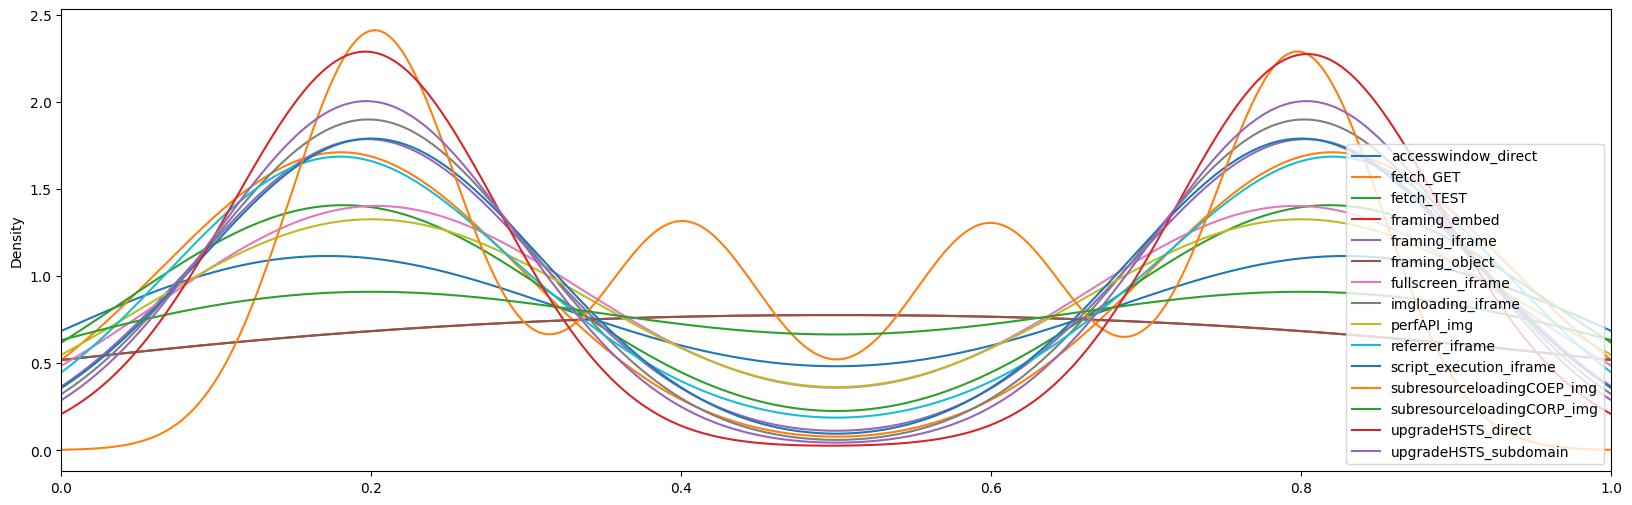

,,count
browser,test_name,
safari macOS 15.2 18.2 selenium real,subresourceloadingCOEP_img,87
firefox_beta Android 11 123.0b9 intent real,subresourceloadingCOEP_img,76
chrome iPadOS 17.3.1 122.0.6261.89 intent real,subresourceloadingCOEP_img,72
safari macOS 14.3.1 17.3.1 selenium real,subresourceloadingCOEP_img,57
firefox Ubuntu 22.04 123 selenium headless,subresourceloadingCOEP_img,46
firefox Ubuntu 22.04 121 selenium headless,subresourceloadingCOEP_img,46
firefox Ubuntu 22.04 122 selenium headless,subresourceloadingCOEP_img,33
safari macOS 15.2 18.2 selenium real,referrer_iframe,16
firefox Ubuntu 22.04 133 selenium headless,subresourceloadingCOEP_img,11


proportion
0.200000    1446
0.800000    1410
0.400000     364
0.600000     362
0.833333     135
0.166667     135
0.750000      48
0.250000      48
0.857143      31
0.142857      31
0.500000      24
0.666667      18
0.333333      18
0.900000      12
0.100000      12
0.125000      11
0.875000      11
0.111111      10
0.888889      10
0.777778       3
0.222222       3
0.153846       2
0.846154       2
0.300000       2
0.700000       2
0.555556       1
0.444444       1
0.642857       1
0.357143       1
0.083333       1
0.916667       1
0.909091       1
0.090909       1
0.923077       1
0.076923       1
0.937500       1
0.062500       1
0.928571       1
0.071429       1
Name: count, dtype: int64

In [35]:
# What is the ration of different outcomes for tests with more than one outcome?
test = df.groupby(["test_name", "org_scheme", "org_host", "resp_scheme", "resp_host", "relation_info", "response_id", "browser", "resp_type"])['outcome_str'].value_counts(normalize=True).reset_index()

# General information on tests with more than one outcome
mean_max_value = test.loc[test["proportion"] != 1.0].groupby(["test_name", "org_scheme", "org_host", "resp_scheme", "resp_host", "relation_info", "response_id", "browser", "resp_type"])["proportion"].max().reset_index()
display(mean_max_value["proportion"].agg(["count", "mean", "std", "min", "median", "max"]))        
display(mean_max_value.groupby("test_name")["proportion"].agg(["count", "mean", "std", "min", "median", "max"]))

# Tests where the most common and second most commont outcome is close (majority vote only is between 0.5 and 0.79) -> noisy test, majority vote might be wrong?
display(test.loc[(test['proportion'] >= 0.5) & (test['proportion'] <= 0.79)]["test_name"].value_counts())

# As a density plot
ax = test.loc[test["proportion"] != 1.0].groupby("test_name")["proportion"].plot(kind="kde", xlim=(0, 1), legend=True, figsize=(20, 6))
ax.iloc[0].legend(loc='lower right')  # Customize the legend location
plt.show()

# Same grouped by browsers
display(test.loc[(test['proportion'] >= 0.5) & (test['proportion'] <= 0.79)].groupby("browser")["test_name"].value_counts().to_frame().sort_values(by="count", ascending=False))

# Raw value counts of proportions
with pd.option_context("display.max_rows", 77):
    display(test.loc[test["proportion"] != 1.0]["proportion"].value_counts())

### Majority Voting
- Perform majority voting
- Only firefox_beta Android 11 (basic) subresourceloadingCOEP_img has 8 tests with the same mode, we simply choose the first in such cases

In [47]:
df = df_org
df = df.loc[df["test_status"] == 0]

In [48]:
df_stab = df

# Only keep one row for each test
# If the test had non-deterministic results, use majority voting! (only works reliably if there a enough repetitions of the tests runs, >= 5)

print("Original data entries", len(df))

# Majority voting (pd.Series.mode returns the most frequest item) (quite slow)

df = df.groupby(["test_id", "browser"], observed=True)["outcome_str"].agg(pd.Series.mode).reset_index()
print("Only one row for each test (per browser; majority voting)", len(df))

Original data entries 14976135
Only one row for each test (per browser; majority voting) 2834336


In [49]:
# Merge back additional required properties!
# ["name", "test_name", "org_scheme", "org_host", "resp_scheme", "resp_host", "relation_info", "response_id", "resp_type", "label", 'org_origin', 'resp_origin', 'status_code', 'raw_header']

df = df.merge(df_stab.drop_duplicates(subset=["test_id", "browser"]), on=["test_id", "browser"], how="left", suffixes=["", "_ignore"])


In [50]:
# Tests with same mode?! maybe rerun again?!
with pd.option_context("display.max_colwidth", None):
    # Firefox subresourceloadingCOEP_img
    # Ignore, indeterministic behavior.
    display(df.loc[(df["browser"] == 'firefox_beta Android 11 123.0b9 intent real') & (df['outcome_str'].apply(lambda x: isinstance(x, np.ndarray)))][["outcome_str", "full_url"]])
    
    # Brave (Android) HSTS
    # One timeout issue?
    display(df.loc[(df["browser"] == 'brave Android 11 1.62.165_shield intent real') & (df['outcome_str'].apply(lambda x: isinstance(x, np.ndarray)))][["outcome_str", "full_url"]])

    # Safari (MacOS) subresourceloadingCOEP_img 
    # ??
    display(df.loc[(df["browser"] == 'safari macOS 15.2 18.2 selenium real') & (df['outcome_str'].apply(lambda x: isinstance(x, np.ndarray)))][["outcome_str", "full_url"]])

,outcome_str,full_url
2454909,"[{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'error', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}, {'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'load'}, 'window.crossOriginIsolated': False}]",http://sub.headers.websec.saarland/_hp/tests/subresource-loading-coep.sub.html?timeout=10&resp_type=basic&browser_id=64&label=COEP&first_id=58&last_id=58&scheme=http&run_id=645058ab2c9143599e445a365f502857
2454925,"[{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}, {'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'load'}, 'window.crossOriginIsolated': False}]",http://sub.headers.websec.saarland/_hp/tests/subresource-loading-coep.sub.html?timeout=10&resp_type=basic&browser_id=64&label=COEP&first_id=59&last_id=59&scheme=http&run_id=141f1711bc294e1db4f626281598088a
2455021,"[{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'error', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}, {'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'load'}, 'window.crossOriginIsolated': False}]",http://sub.headers.websec.saarland/_hp/tests/subresource-loading-coep.sub.html?timeout=10&resp_type=basic&browser_id=64&label=COEP&first_id=65&last_id=65&scheme=http&run_id=50b6106d332c437f8a76f52d34f6bbb6
2455389,"[{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}, {'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'load'}, 'window.crossOriginIsolated': False}]",http://sub.headers.websec.saarland/_hp/tests/subresource-loading-coep.sub.html?timeout=10&resp_type=basic&browser_id=64&label=COEP&first_id=66&last_id=66&scheme=http&run_id=db5f71465546446eacf64876591928e2
2455533,"[{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}, {'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'load'}, 'window.crossOriginIsolated': False}]",http://sub.headers.websec.saarland/_hp/tests/subresource-loading-coep.sub.html?timeout=10&resp_type=basic&browser_id=64&label=COEP&first_id=64&last_id=64&scheme=http&run_id=f0376075d30b402585774303b11dcda4
2455565,"[{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'error', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}, {'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}]",http://sub.headers.websec.saarland/_hp/tests/subresource-loading-coep.sub.html?timeout=10&resp_type=basic&browser_id=64&label=COEP&first_id=66&last_id=66&scheme=http&run_id=db5f71465546446eacf64876591928e2
2498525,"[{'image-events': {'swag.jpg': 'error', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}, {'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'load'}, 'window.crossOriginIsolated': False}]",https://sub.headers.websec.saarland/_hp/tests/subresource-loading-coep.sub.html?timeout=10&resp_type=basic&browser_id=64&label=COEP&first_id=59&last_id=59&scheme=https&run_id=c38e1479189245d8a7b5ec707d79f6a0
2499053,"[{'image-events': {'swag.jpg': 'error', 'swag-same-site.

,outcome_str,full_url
2711744,"[{'response.redirected': False}, {'response.redirected': True}]",http://sub.headers.websec.saarland/_hp/tests/upgrade-hsts.sub.html?timeout=20&resp_type=parsing&browser_id=68&label=HSTS&first_id=32042&last_id=32042&scheme=http&run_id=07126172ca214a138ddc6eb44dc91142


,outcome_str,full_url
2433407,"[{'image-events': {'swag.jpg': 'error', 'swag-same-site.jpg': 'error', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}, {'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'error', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}]",http://sub.headers.websec.saarland/_hp/tests/subresource-loading-coep.sub.html?timeout=5&resp_type=parsing&browser_id=73&label=COEP&first_id=20266&last_id=20270&scheme=http
2433423,"[{'image-events': {'swag.jpg': 'error', 'swag-same-site.jpg': 'error', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}, {'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'error', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}]",http://sub.headers.websec.saarland/_hp/tests/subresource-loading-coep.sub.html?timeout=5&resp_type=parsing&browser_id=73&label=COEP&first_id=20266&last_id=20270&scheme=http
2433439,"[{'image-events': {'swag.jpg': 'error', 'swag-same-site.jpg': 'error', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}, {'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'error', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}]",http://sub.headers.websec.saarland/_hp/tests/subresource-loading-coep.sub.html?timeout=5&resp_type=parsing&browser_id=73&label=COEP&first_id=20266&last_id=20270&scheme=http
2433615,"[{'image-events': {'swag.jpg': 'error', 'swag-same-site.jpg': 'error', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}, {'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'error', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}]",http://sub.headers.websec.saarland/_hp/tests/subresource-loading-coep.sub.html?timeout=5&resp_type=parsing&browser_id=73&label=COEP&first_id=20281&last_id=20285&scheme=http
2433647,"[{'image-events': {'swag.jpg': 'error', 'swag-same-site.jpg': 'error', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}, {'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'error', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}]",http://sub.headers.websec.saarland/_hp/tests/subresource-loading-coep.sub.html?timeout=5&resp_type=parsing&browser_id=73&label=COEP&first_id=20281&last_id=20285&scheme=http
2433663,"[{'image-events': {'swag.jpg': 'error', 'swag-same-site.jpg': 'error', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}, {'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'error', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}]",http://sub.headers.websec.saarland/_hp/tests/subresource-loading-coep.sub.html?timeout=5&resp_type=parsing&browser_id=73&label=COEP&first_id=20281&last_id=20285&scheme=http
2433679,"[{'image-events': {'swag.jpg': 'error', 'swag-same-site.jpg': 'error', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}, {'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'error', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}]",http://sub.headers.websec.saarland/_hp/tests/subresource-loading-coep.sub.html?timeout=5&resp_type=parsing&browser_id=73&label=COEP&first_id=20281&last_id=20285&scheme=http
2434431,"[{'image-events': {'swag.jpg': 'error', 'swag-same-site.jpg': 'error', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}, {'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'error', 'swag-cross-site.jpg': 

In [51]:
# If several values occur the same, the mode is an np.ndarray and not a string!
# If we have exactly 5 repetitions for each test, the issue cannot exist!
# However, our repeat system only enables us to have 5+ results for each test
print("Tests with the same mode (highest frequency outcome):")
display(df.loc[df['outcome_str'].apply(lambda x: isinstance(x, np.ndarray))].groupby(["browser", "resp_type", "test_name"])["outcome_str"].count())

# In the rare cases, where it actually matters, we can just take the first? (this might be noise in the generated trees and other summaries!)
# These are unstable tests that might indicate random behavior in the browser (e.g., firefox COEP_img)
df['outcome_str'] = df['outcome_str'].apply(lambda x: x[0] if isinstance(x, np.ndarray) else x)

Tests with the same mode (highest frequency outcome):


browser                                       resp_type  test_name                 
brave Android 11 1.62.165_shield intent real  parsing    upgradeHSTS_direct             1
firefox_beta Android 11 123.0b9 intent real   basic      subresourceloadingCOEP_img     8
safari macOS 15.2 18.2 selenium real          parsing    subresourceloadingCOEP_img    11
Name: outcome_str, dtype: int64

# Browser differences
- Most tests have one outcome only (not interesting for us)
- 4374 tests have two outcomes, 58 tests have three outcomes
- All test rows: 2125752, should be: 2125752, Rows with more than one outcome: 53184, Tests with more than one outcome: 4432
- **Update December: 5491 have two outcomes, 121 have three outcomes**

In [52]:
# Most tests have exactly one outcome, quite some have two, couple have three!
res = df.groupby(["resp_type", "test_name", "org_scheme", "org_host", "resp_scheme", "resp_host", "relation_info", "response_id", "test_id"], observed=True)
res = res["outcome_str"].agg("nunique")
display(res.value_counts().to_frame())

,count
outcome_str,
1,171534
2,5491
3,121


In [53]:
4432/(9992+167154)*100

2.501891095480564

## Differences per test group
- Basic:
    - subresourceloadingCORP_object 100% of test have different results (WebKit does not support postMessages on objects?)
    - couple of others have 20%+ differences
    - others have 0% 
- Parsing:
    - ~~oac_window.open has 99% (only supported in chromium)~~
    - other tests with differences are between 0.5% (fetch_GET) and 5% (upgradeHSTS_direct)

In [54]:
# Basic:
# subresourceloadingCORP_object has different results for 100% of tests
# couple of others have 20%+ differences
# couple have 0%

# Parsing:
# Test groups have between 0.5 - 5% of tests with different outcomes
# Highest: upgradeHSTS_direct with 4.69%
r = res.reset_index()
r["diff"] = r["outcome_str"] != 1
display(r.groupby(["resp_type", "test_name", "relation_info"])["diff"].agg(["count", "sum", "mean"]).sort_values("mean", ascending=False))
display(r.groupby(["resp_type", "test_name", "relation_info"])["diff"].agg(["mean"]).describe())
display(r.groupby(["test_name", "relation_info"])["diff"].agg(["mean"]).describe())

count  sum      mean
resp_type test_name                     relation_info                       
basic     subresourceloadingCORP_object direct            176  176  1.000000
          subresourceloadingCOEP_img    direct            176   88  0.500000
          referrer_iframe               window.open       256  117  0.457031
          fullscreen_iframe             direct            384  142  0.369792
          framing_embed                 direct            560  186  0.332143
          framing_object                direct            560  186  0.332143
          fullscreen_iframe             child_allow       384  113  0.294271
          perfAPI_img                   direct            208   55  0.264423
          framing_object                nested            560  120  0.214286
          framing_embed                 sandbox           560  120  0.214286
                                        nested            560  120  0.214286
          framing_object                sandbox           560  120  0.214286
          accesswindow_direct           direct            176   28  0.159091
          upgradeHSTS_direct            direct             28    4  0.142857
parsing   upgradeHSTS_direct            direct           6648  855  0.128610
basic     script_execution_iframe       sandbox           272   21  0.077206
          upgradeHSTS_subdomain         subdomain          28    2  0.071429
          referrer_iframe               iframe            256   18  0.070312
          fullscreen_iframe             child             384   23  0.059896
parsing   upgradeHSTS_subdomain         subdomain        6648  321  0.048285
basic     imgloading_iframe             direct            272   13  0.047794
parsing   fullscreen_iframe             child_allow      7760  368  0.047423
          imgloading_iframe             direct           5420  257  0.047417
          script_execution_iframe       direct           5452  242  0.044387
          fullscreen_iframe             direct           7760  300  0.038660
          subresourceloadingCOEP_img    direct           5274  154  0.029200
          framing_iframe                direct          17560  421  0.023975
          sniffing_script               direct           1778   42  0.023622
basic     subresourceloadingCOEP_img    sandbox           176    4  0.022727
parsing   referrer_iframe               iframe           5594  113  0.020200
          perfAPI_img                   direct           3202   49  0.015303
          subresourceloadingCORP_img    direct           6714  102  0.015192
basic     framing_iframe                sandbox           560    8  0.014286
parsing   framing_iframe                nested          17560  172  0.009795
          accesswindow_direct           direct           5312   48  0.009036
          fetch_GET                     simple          16118  137  0.008500
                                        custom_headers  16118  126  0.007817
          fetch_TEST                    custom_method   16118  126  0.007817
          fetch_GET                     credentials     16118  114  0.007073
basic     subresourceloadingCORP_img    direct            176    1  0.005682
          fetch_GET                     simple             96    0  0.000000
                                        credentials        96    0  0.000000
                                        custom_headers     96    0  0.000000
          fullscreen_iframe             child_sandbox     384    0  0.000000
          fetch_TEST                    custom_method      96    0  0.000000
          framing_iframe                direct            560    0  0.000000
                                        nested            560    0  0.000000
          subresourceloadingCORP_img    nested            176    0  0.000000
                                        sandbox           176    0  0.000000
          script_execution_iframe       direct            272    0  0.000000
          sniffing_script               direct      

,mean
count,51.000000
mean,0.110011
std,0.180980
min,0.000000
25%,0.007445
50%,0.029200
75%,0.150974
max,1.000000


,mean
count,33.000000
mean,0.113444
std,0.196315
min,0.000000
25%,0.013848
50%,0.042278
75%,0.128670
max,1.000000


In [55]:
r.groupby(["test_name", "relation_info"])["diff"].sum()

test_name                      relation_info 
accesswindow_direct            direct             76
fetch_GET                      credentials       114
                               custom_headers    126
                               simple            137
fetch_TEST                     custom_method     126
framing_embed                  direct            186
                               nested            120
                               sandbox           120
framing_iframe                 direct            421
                               nested            172
                               sandbox             8
framing_object                 direct            186
                               nested            120
                               sandbox           120
fullscreen_iframe              child              23
                               child_allow       481
                               child_sandbox       0
                               direct            442


In [56]:
# Select only test rows with more than one outcome
tests_with_mult_outcomes = r.loc[r["diff"]].set_index(["test_name", "org_scheme", "org_host", "resp_scheme", "resp_host", "relation_info", "response_id"])
df_mult = df.loc[df[["test_name", "org_scheme", "org_host", "resp_scheme", "resp_host", "relation_info", "response_id"]].apply(tuple, axis=1).isin(tests_with_mult_outcomes.index)]
tests_with_more_than_one_outcome = df_mult.drop_duplicates(subset=["test_name", "org_scheme", "org_host", "resp_scheme", "resp_host", "relation_info", "response_id"])


all_tests_should_be =  df_org.loc[df_org["test_status"] == 0]["test_id"].nunique() * df_org["browser"].nunique() # (num parsing tests + num_basic_tests) * num_browsers (168774+10456)
print(f"All test rows: {len(df)}, should be: {all_tests_should_be}, Rows with more than one outcome: {len(df_mult)}, Tests with more than one outcome: {len(tests_with_more_than_one_outcome)}")

All test rows: 2834336, should be: 2834336, Rows with more than one outcome: 89792, Tests with more than one outcome: 5612


## Browser similarity
- Matrix for differences between all browsers split by all results, only parsing, only basic, only specific test types
- In general:
    - Chromium != Firefox != WebKit
    - Brave is different to Chrome (whereas Opera, Edge are equal to Chrome?)
    - Firefox and WebKit are close together
    - Differences between Mobile and Desktop exist but are small (for all brave, chrome, firefox, safari)

In [57]:
df["b_short"] = df["os"].apply(lambda x: x.split(" ")[0]) + " " + df["name"] + "(" + df["version"] + ")"

In [58]:
# Simmilarity between browsers and versions!

# Function to calculate absolute and percentage overlap
def calculate_overlap(df, col1, col2):
    df = df[[col1, col2]].dropna()
    df.columns.values[0] = 0
    df.columns.values[1] = 1
    absolute_overlap = (df[0] == df[1]).sum()
    unique_rows = len(df)
    diff_rows = unique_rows - absolute_overlap
    percentage_diff = (diff_rows / unique_rows) * 100
    return diff_rows, percentage_diff, unique_rows

def rename_rows(df):
    for row_index in df.index:
        for column_name in df.columns:
            if row_index.startswith(column_name.split(',')[0]):
                df.rename(index={row_index: column_name}, inplace=True)
                break  # Stop searching for matching column names once found
    return df


def display_overlap(df, show_all=True, name="All"):
    print(name)
    sim_frame = df.set_index(["test_id", "b_short"])["outcome_str"].unstack().astype("str")
    sim_frame = sim_frame.reset_index().drop(columns=["test_id"])
    # Create a dictionary to store results
    results = {}
    matrix = {}
    
    # Iterate through all pairs of columns
    for i, col1 in enumerate(sim_frame.columns):
        for col2 in sim_frame.columns:
            key = f"{col1}_vs_{col2}"
            results[key] = calculate_overlap(sim_frame, col1, col2)
            try:
                l = matrix[col1]
            except KeyError:
                l = {}
            # 0 for absolute count of differences, 1 for percentage
            l[col2] = results[key][0]
            matrix[col1] = l
            
    # Convert the results to a DataFrame for better visualization
    results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Absolute Diff', 'Percentage Diff', "Count"])

    s = {}
    for key, value in matrix.items():
        value_tuple = tuple(value.items())
        try:
            s[value_tuple].append(key)
        except KeyError:
            s[value_tuple] = [key]
    s_swapped = {", ".join(value): dict(key) for key, value in s.items()}
    # Display difference matrix
    with pd.option_context("display.max_columns", 28):
        final_frame = pd.DataFrame(s_swapped).drop_duplicates()
        final_frame = rename_rows(final_frame)
        display(final_frame)
        return final_frame

In [59]:
display_overlap(df)

for name, group in df.groupby("resp_type"):
    display_overlap(group, show_all=True, name=name)

for name, group in df.groupby("test_name"):
    display_overlap(group, show_all=False, name=name)

All


,Android brave(1.62.165_shield),Android chrome(121.0.6167.180),Android firefox_beta(123.0b9),Ubuntu brave(v1.62.156 (121.0.6167.139)),Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)),Ubuntu chrome(120),"Ubuntu chrome(121), Ubuntu chrome(122)",Ubuntu chrome(131),Ubuntu firefox(121),Ubuntu firefox(122),Ubuntu firefox(123),Ubuntu firefox(133),iPadOS chrome(122.0.6261.89),macOS safari(17.3.1),macOS safari(18.2)
Android brave(1.62.165_shield),0,137,3083,29,309,169,154,440,3075,3072,3070,2992,2721,2752,4219
Android chrome(121.0.6167.180),137,0,3107,161,444,36,21,307,3099,3096,3094,3017,2759,2790,4256
Android firefox_beta(123.0b9),3083,3107,0,3098,2822,3141,3126,2842,90,83,87,196,2820,2769,3439
Ubuntu brave(v1.62.156 (121.0.6167.139)),29,161,3098,0,294,157,142,428,3064,3061,3059,2995,2724,2763,4234
Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)),309,444,2822,294,0,440,423,137,2788,2785,2783,2719,2902,2941,3962
Ubuntu chrome(120),169,36,3141,157,440,0,17,303,3107,3104,3102,3039,2781,2820,4290
"Ubuntu chrome(121), Ubuntu chrome(122)",154,21,3126,142,423,17,0,286,3092,3089,3087,3024,2766,2805,4275
Ubuntu chrome(131),440,307,2842,428,137,303,286,0,2808,2805,2803,2740,2936,2975,3995
Ubuntu firefox(121),3075,3099,90,3064,2788,3107,3092,2808,0,27,33,162,2796,2737,3434
Ubuntu firefox(122),3072,3096,83,3061,2785,3104,3089,2805,27,0,38,149,2793,2740,3429


basic


,Android brave(1.62.165_shield),Android chrome(121.0.6167.180),Android firefox_beta(123.0b9),Ubuntu brave(v1.62.156 (121.0.6167.139)),Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)),Ubuntu chrome(120),"Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",Ubuntu firefox(121),Ubuntu firefox(122),Ubuntu firefox(123),Ubuntu firefox(133),iPadOS chrome(122.0.6261.89),macOS safari(17.3.1),macOS safari(18.2)
Android brave(1.62.165_shield),0,64,597,16,10,70,71,573,573,574,575,1504,1557,1483
Android chrome(121.0.6167.180),64,0,551,77,74,6,7,527,527,528,529,1471,1524,1450
Android firefox_beta(123.0b9),597,551,0,599,607,557,558,54,54,51,64,1204,1155,1211
Ubuntu brave(v1.62.156 (121.0.6167.139)),16,77,599,0,8,71,72,575,575,576,577,1506,1559,1485
Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)),10,74,607,8,0,68,67,583,583,584,585,1514,1567,1493
Ubuntu chrome(120),70,6,557,71,68,0,1,533,533,534,535,1477,1530,1456
"Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",71,7,558,72,67,1,0,534,534,535,536,1478,1531,1457
Ubuntu firefox(121),573,527,54,575,583,533,534,0,12,15,26,1166,1117,1188
Ubuntu firefox(122),573,527,54,575,583,533,534,12,0,15,26,1166,1117,1188
Ubuntu firefox(123),574,528,51,576,584,534,535,15,15,0,23,1167,1118,1189


parsing


,Android brave(1.62.165_shield),Android chrome(121.0.6167.180),Android firefox_beta(123.0b9),Ubuntu brave(v1.62.156 (121.0.6167.139)),Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)),Ubuntu chrome(120),"Ubuntu chrome(121), Ubuntu chrome(122)",Ubuntu chrome(131),Ubuntu firefox(121),Ubuntu firefox(122),Ubuntu firefox(123),Ubuntu firefox(133),iPadOS chrome(122.0.6261.89),macOS safari(17.3.1),macOS safari(18.2)
Android brave(1.62.165_shield),0,73,2486,13,299,99,83,369,2502,2499,2496,2417,1217,1195,2736
Android chrome(121.0.6167.180),73,0,2556,84,370,30,14,300,2572,2569,2566,2488,1288,1266,2806
Android firefox_beta(123.0b9),2486,2556,0,2499,2215,2584,2568,2284,36,29,36,132,1616,1614,2228
Ubuntu brave(v1.62.156 (121.0.6167.139)),13,84,2499,0,286,86,70,356,2489,2486,2483,2418,1218,1204,2749
Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)),299,370,2215,286,0,372,356,70,2205,2202,2199,2134,1388,1374,2469
Ubuntu chrome(120),99,30,2584,86,372,0,16,302,2574,2571,2568,2504,1304,1290,2834
"Ubuntu chrome(121), Ubuntu chrome(122)",83,14,2568,70,356,16,0,286,2558,2555,2552,2488,1288,1274,2818
Ubuntu chrome(131),369,300,2284,356,70,302,286,0,2274,2271,2268,2204,1458,1444,2538
Ubuntu firefox(121),2502,2572,36,2489,2205,2574,2558,2274,0,15,18,136,1630,1620,2246
Ubuntu firefox(122),2499,2569,29,2486,2202,2571,2555,2271,15,0,23,123,1627,1623,2241


accesswindow_direct


,Android brave(1.62.165_shield),Android chrome(121.0.6167.180),Android firefox_beta(123.0b9),"Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)","Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",Ubuntu firefox(133),iPadOS chrome(122.0.6261.89),macOS safari(17.3.1),macOS safari(18.2)
Android brave(1.62.165_shield),0,2,57,11,67,61,37,29,49
Android chrome(121.0.6167.180),2,0,57,11,67,61,37,29,49
Android firefox_beta(123.0b9),57,57,0,68,12,4,36,28,16
"Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",11,11,68,0,56,64,40,40,60
"Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",67,67,12,56,0,8,40,40,28
Ubuntu firefox(133),61,61,4,64,8,0,32,32,20
iPadOS chrome(122.0.6261.89),37,37,36,40,40,32,0,8,28
macOS safari(17.3.1),29,29,28,40,40,32,8,0,20
macOS safari(18.2),49,49,16,60,28,20,28,20,0


fetch_GET


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",Ubuntu firefox(133),"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",macOS safari(18.2)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",0,291,273,94,246
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",291,0,18,197,227
Ubuntu firefox(133),273,18,0,179,209
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",94,197,179,0,152
macOS safari(18.2),246,227,209,152,0


fetch_TEST


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",macOS safari(18.2)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",0,101,55,111
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133)",101,0,46,44
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",55,46,0,56
macOS safari(18.2),111,44,56,0


framing_embed


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Android firefox_beta(123.0b9), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1), macOS safari(18.2)"
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Android firefox_beta(123.0b9), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133)",0,426
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1), macOS safari(18.2)",426,0


framing_iframe


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)",Ubuntu firefox(133),"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",macOS safari(18.2)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,517,39,484,95,221
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",517,0,478,57,422,440
"Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)",39,478,0,445,56,182
Ubuntu firefox(133),484,57,445,0,389,419
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",95,422,56,389,0,126
macOS safari(18.2),221,440,182,419,126,0


framing_object


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Android firefox_beta(123.0b9), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1), macOS safari(18.2)"
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Android firefox_beta(123.0b9), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133)",0,426
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1), macOS safari(18.2)",426,0


fullscreen_iframe


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)","Ubuntu firefox(133), iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",macOS safari(18.2)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,905,9,900,941
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",905,0,896,9,54
"Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)",9,896,0,891,932
"Ubuntu firefox(133), iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",900,9,891,0,45
macOS safari(18.2),941,54,932,45,0


imgloading_iframe


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)",Ubuntu firefox(133),"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",macOS safari(18.2)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,243,2,237,41,68
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",243,0,243,6,202,237
"Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)",2,243,0,237,41,66
Ubuntu firefox(133),237,6,237,0,196,231
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",41,202,41,196,0,67
macOS safari(18.2),68,237,66,231,67,0


perfAPI_img


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",Ubuntu firefox(133),iPadOS chrome(122.0.6261.89),macOS safari(17.3.1),macOS safari(18.2)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",0,66,64,22,74,44
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",66,0,18,88,40,94
Ubuntu firefox(133),64,18,0,86,54,92
iPadOS chrome(122.0.6261.89),22,88,86,0,52,30
macOS safari(17.3.1),74,40,54,52,0,82
macOS safari(18.2),44,94,92,30,82,0


referrer_iframe


,Android brave(1.62.165_shield),Android chrome(121.0.6167.180),"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",Ubuntu brave(v1.62.156 (121.0.6167.139)),Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)),Ubuntu chrome(120),"Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",Ubuntu firefox(133),"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",macOS safari(18.2)
Android brave(1.62.165_shield),0,134,151,16,10,140,141,148,133,156
Android chrome(121.0.6167.180),134,0,174,147,144,6,7,172,170,192
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",151,174,0,153,161,180,181,3,26,33
Ubuntu brave(v1.62.156 (121.0.6167.139)),16,147,153,0,8,141,142,150,135,158
Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)),10,144,161,8,0,138,137,158,143,166
Ubuntu chrome(120),140,6,180,141,138,0,1,178,176,198
"Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",141,7,181,142,137,1,0,179,177,199
Ubuntu firefox(133),148,172,3,150,158,178,179,0,23,30
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",133,170,26,135,143,176,177,23,0,23
macOS safari(18.2),156,192,33,158,166,198,199,30,23,0


script_execution_iframe


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)",Ubuntu firefox(133),"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",macOS safari(18.2)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,216,2,214,43,85
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",216,0,214,2,215,225
"Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)",2,214,0,212,41,83
Ubuntu firefox(133),214,2,212,0,213,223
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",43,215,41,213,0,42
macOS safari(18.2),85,225,83,223,42,0


sniffing_script


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133)",Ubuntu chrome(120),"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",macOS safari(18.2)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",0,18,16,6,22
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133)",18,0,34,12,12
Ubuntu chrome(120),16,34,0,22,38
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",6,12,22,0,16
macOS safari(18.2),22,12,38,16,0


subresourceloadingCOEP_img


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",Android firefox_beta(123.0b9),Ubuntu firefox(121),Ubuntu firefox(122),Ubuntu firefox(123),Ubuntu firefox(133),iPadOS chrome(122.0.6261.89),macOS safari(17.3.1),macOS safari(18.2)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",0,117,97,94,92,95,91,77,103
Android firefox_beta(123.0b9),117,0,76,69,73,69,130,136,157
Ubuntu firefox(121),97,76,0,27,33,33,104,94,138
Ubuntu firefox(122),94,69,27,0,38,20,101,97,133
Ubuntu firefox(123),92,73,33,38,0,38,97,79,127
Ubuntu firefox(133),95,69,33,20,38,0,101,99,133
iPadOS chrome(122.0.6261.89),91,130,104,101,97,101,0,42,87
macOS safari(17.3.1),77,136,94,97,79,99,42,0,71
macOS safari(18.2),103,157,138,133,127,133,87,71,0


subresourceloadingCORP_img


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",Ubuntu firefox(133),iPadOS chrome(122.0.6261.89),macOS safari(17.3.1),macOS safari(18.2)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",0,57,52,36,37,86
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",57,0,5,45,44,63
Ubuntu firefox(133),52,5,0,40,41,58
iPadOS chrome(122.0.6261.89),36,45,40,0,1,50
macOS safari(17.3.1),37,44,41,1,0,51
macOS safari(18.2),86,63,58,50,51,0


subresourceloadingCORP_object


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1), macOS safari(18.2)"
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",0,32,176
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133)",32,0,176
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1), macOS safari(18.2)",176,176,0


upgradeHSTS_direct


,Android brave(1.62.165_shield),Android chrome(121.0.6167.180),Android firefox_beta(123.0b9),"Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)","Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",Ubuntu firefox(133),"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",macOS safari(18.2)
Android brave(1.62.165_shield),0,1,244,2,204,246,245,86,782
Android chrome(121.0.6167.180),1,0,245,3,205,247,246,87,783
Android firefox_beta(123.0b9),244,245,0,246,44,2,3,284,571
"Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",2,3,246,0,202,244,243,84,784
"Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)",204,205,44,202,0,42,41,278,586
"Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",246,247,2,244,42,0,1,282,573
Ubuntu firefox(133),245,246,3,243,41,1,0,283,572
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",86,87,284,84,278,282,283,0,828
macOS safari(18.2),782,783,571,784,586,573,572,828,0


upgradeHSTS_subdomain


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)",Ubuntu firefox(133),"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",macOS safari(18.2)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,68,32,68,54,277
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",68,0,36,2,80,238
"Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)",32,36,0,36,80,247
Ubuntu firefox(133),68,2,36,0,78,238
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",54,80,80,78,0,291
macOS safari(18.2),277,238,247,238,291,0


## Analysis
- Limit df on responsses that have more than one outcome

In [60]:
# Limit on responses that have more than one outcome!
# This will remove all the branches that are the same in all browsers (and make trees large and confusing)
condition = df.groupby(["test_id"], observed=True)["outcome_str"].transform("nunique") != 1
tree_df = df.loc[condition]
print("Remove tests that are the same in all browsers. Remaining rows:", len(tree_df))

Remove tests that are the same in all browsers. Remaining rows: 89792


In [61]:
# How many rows exist with more than one outcome
with pd.option_context("display.max_rows", 100):
    display(tree_df[["test_name", "label", "relation_info"]].value_counts())

test_name                      label       relation_info 
upgradeHSTS_direct             HSTS        direct            13744
fullscreen_iframe              PP          child_allow        7696
                                           direct             7072
upgradeHSTS_subdomain          HSTS        subdomain          5168
imgloading_iframe              CSP-IMG     direct             4320
framing_iframe                 CSP-FA      direct             3920
subresourceloadingCOEP_img     COEP        direct             3872
script_execution_iframe        CSP-SCRIPT  direct             3872
subresourceloadingCORP_object  CORP        direct             2816
referrer_iframe                RP          iframe             2096
framing_iframe                 CSP-FA      nested             1920
referrer_iframe                RP          window.open        1872
framing_iframe                 XFO         direct             1664
perfAPI_img                    TAO         direct             1664
subr

# Manual analysis
- Noise check/Manual confirmation:
    - Android: http://134.96.225.54:8888/#!/control/emulator-5554

## Helpers

In [62]:
from IPython.display import display, HTML
import os

In [63]:
def show_overlap(test_name, groupby=True, show_all=True):
    d = df.loc[df["test_name"] == test_name]
    if groupby:
        for name, group in d.groupby("resp_type"):
            display_overlap(group, show_all=show_all, name=name)
    else:
        display_overlap(d, show_all=show_all, name="all")


In [165]:
from io import StringIO
import ipywidgets as widgets
from utils import clickable
from functools import partial

class DataFrameWidget(widgets.VBox):
    def __init__(self, df, rows_per_page=20):
        self.df = df
        self.rows_per_page = rows_per_page
        self.page_index = 0
        self.total_pages = (len(df) - 1) // rows_per_page + 1
        
        self.output = widgets.Output()
        
        self.prev_button = widgets.Button(description='Prev')
        self.prev_button.on_click(self.prev_page)
        self.next_button = widgets.Button(description='Next')
        self.next_button.on_click(self.next_page)
        
        self.page_label = widgets.Label(value=f'Page: {self.page_index + 1} / {self.total_pages}')
        
        self.update_output()

        super().__init__(children=[self.output, 
                                   widgets.HBox([self.prev_button, self.next_button]),
                                   self.page_label])
    
    def update_output(self):
        start = self.page_index * self.rows_per_page
        end = min((self.page_index + 1) * self.rows_per_page, len(self.df))
        display_df = self.df.iloc[start:end]
        
        with self.output:
            self.output.clear_output()
            with pd.option_context("display.max_colwidth", 500):
                click_func = partial(clickable, "URL")
                display_df = display_df.style.format({'url': click_func})
                display(display_df)
        self.page_label.value = f'Page: {self.page_index + 1} / {self.total_pages}'
    
    def prev_page(self, _):
        if self.page_index > 0:
            self.page_index -= 1
            self.update_output()
    
    def next_page(self, _):
        if self.page_index < self.total_pages - 1:
            self.page_index += 1
            self.update_output()


def show_response_groups(test_name, relation=None, browser_ids=None):
    splits = {}
    d = tree_df.loc[tree_df["test_name"] == test_name]
    if relation:
        d = d.loc[d["relation_info"] == relation]
    if browser_ids:
        d = d.loc[d["browser_id"].isin(browser_ids)]
    for test_id, group in d.groupby("test_id", observed=True):
        key = group[["browser", "outcome_str"]].drop_duplicates().sort_values("browser")
        key = key.to_csv(index=False)
        try:
            splits[key].append(test_id)
        except (AttributeError, KeyError):
            splits[key] = [test_id]

    tab_contents = []
    
    for i, (key, values) in enumerate(splits.items()):        
        # Prepare content for the tab
        main_output = widgets.Output()
        with main_output:
            print(f"Group {i}")
            display(pd.read_csv(StringIO(key)).groupby("outcome_str")["browser"].unique().apply(sorted).to_dict())
            with pd.option_context("display.max_colwidth", 500):
                cur_data = tree_df.loc[tree_df["test_id"].isin(values)]
                example = cur_data.iloc[0]
                example_url = example["clean_url"]
                example_element_relation = example["test_name"].split("_")[1] + "_" + example["relation_info"]
                example_resp_origin = example["resp_origin"]
                example_resp_id = example["response_id"]
                example_url += f"&t_resp_id={example_resp_id}&t_element_relation={example_element_relation}&t_resp_origin={example_resp_origin}"
                display(example_url)
                
                d_data = cur_data.drop_duplicates(subset=["raw_header", "status_code", "org_origin", "resp_origin", "response_id"]).sort_values(by=["raw_header", "status_code", "org_origin", "resp_origin"])
                d_data["url"] = d_data["clean_url"] + "&t_resp_id=" + d_data["response_id"].astype(str) + "&t_element_relation=" + d_data["test_name"].apply(lambda x: x.split("_")[1]) + "_" + d_data["relation_info"] + "&t_resp_origin=" + d_data["resp_origin"]
                d_data = d_data[["raw_header", "status_code", "org_origin", "resp_origin", "response_id", "test_id", "url"]]

                # Display the DataFrame
                display(DataFrameWidget(d_data))
        
        # Add the content to the tab
        tab_contents.append(main_output)
    
    # Create tabs
    tab = widgets.Tab()
    tab.children = tab_contents

    
    # Set tab titles
    for i in range(len(tab_contents)):
        tab.set_title(i, f"Group {i}")
    
    display(tab)        

In [65]:
def show_outcome_nums(test_name):
    display(pd.concat([df.loc[df["test_name"] == test_name].pivot_table("test_id", "outcome_str", aggfunc="nunique"), tree_df.loc[tree_df["test_name"] == test_name].pivot_table("test_id", "outcome_str", aggfunc="nunique")], axis=1))

def show_response_nums(test_name):
    display(tree_df.loc[tree_df["test_name"] == test_name].groupby("resp_type")["raw_header"].unique().apply(len))
    display(df.loc[df["test_name"] == test_name].groupby("resp_type")["raw_header"].unique().apply(len))

## accesswindow_direct/COOP window-references-coop.sub.html
- Testfile: `window-references-coop.sub.html`
- Testnames: accesswindow_direct
- Header: COOP
- Basic:
    - Android chrome (121), Ubuntu chrome (120-122), edge (121), brave (121) are identical
    - Android: Opera + brave sligthly different?
    - Safari, Firefox (all platforms) are identical
    - The two groups have 28 differences
- Parsing:
    - Ubuntu chrome (120-122), edge (121), brave (121), opera (Android 121) are identical
    - Android: Brave + chrome identical
    - Firefox desktop identical
    - Safari almost identical to Chrome/Brave Android?
    - ...
- **Small amount of noise: mostly opera android**
- **Everything entered into google sheets**

In [66]:
test_name = 'accesswindow_direct'

In [67]:
show_overlap(test_name, groupby=True, show_all=True)

basic


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133), iPadOS chrome(122.0.6261.89), macOS safari(17.3.1), macOS safari(18.2)"
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",0,28
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133), iPadOS chrome(122.0.6261.89), macOS safari(17.3.1), macOS safari(18.2)",28,0


parsing


,Android brave(1.62.165_shield),Android chrome(121.0.6167.180),Android firefox_beta(123.0b9),"Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)","Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",Ubuntu firefox(133),iPadOS chrome(122.0.6261.89),macOS safari(17.3.1),macOS safari(18.2)
Android brave(1.62.165_shield),0,2,29,11,39,33,9,1,21
Android chrome(121.0.6167.180),2,0,29,11,39,33,9,1,21
Android firefox_beta(123.0b9),29,29,0,40,12,4,36,28,16
"Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",11,11,40,0,28,36,12,12,32
"Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",39,39,12,28,0,8,40,40,28
Ubuntu firefox(133),33,33,4,36,8,0,32,32,20
iPadOS chrome(122.0.6261.89),9,9,36,12,40,32,0,8,28
macOS safari(17.3.1),1,1,28,12,40,32,8,0,20
macOS safari(18.2),21,21,16,32,28,20,28,20,0


In [68]:
# Noise check/Manual confirmation:
# Android: http://134.96.225.54:8888/#!/control/emulator-5554


# Noise vs edge-case confirmation ?!
# Group 0 opera is in wrong group (noise)

# Group 5: confirmed 204 is handled differently on iPad

# Group 6: confirmed iPad is in the other group; not sure why? probably COOP applies before the download? (the difference between 2 is that \n is at the end, and the difference to 9 is that the COOP value is blocking)

# Group 7 opera is also in the firefox group (recorded result was noisy?)
# Group 8 opera + brave stay the same/no noise; actual difference might be: only chrome applies redirect + COOP!
# Difference between (0,1) and (7,8) is that the latter uses http://sub.headers.websec.saarland; seems like opera + brave do not auto-update this origin (exception?)


# Final Groups:
# 0+1 COOP only active on HTTPS, even though resp_origin is HTTP COOP is active in chromium-based browsers due to HTTPS auto-upgrade; (opera had noise once thus 2 groups)
# 2,9 Varying download behavior: download triggered due to \n in response. Safari (+ Android without Opera?) download pages are treated similarily to about:blank? (brave + chrome had noise once thus 2 groups)
# More info! On Android object Window is the result if the file already exist, for the first file the result is null, this is due to automatic downloads only if the file is not already existing, otherwise there is a popup that needs user confirmation
# 3 \r, \t, or space at the beginning or end of header name allowed in all non-firefox browsers;
# 4 1. Two headers, one empty: COOP active in Firefox, not-active in other browsers (which behavior is correct?), 2. \r at the end of the header name: works in Firefox, does not work in the other browsers!
# 5 Status code 204 + COOP works on iPad; does not work in other browsers (bug?)
# 6 similar to 2, only difference iPad in other group; (\n at the end!)
# 7,8 Similar to 0+1, however brave (Android) does not auto update to https here (due to shields being disabled on sub.headers.websec.saarland!) (opera had noise once thus 2 groups)

show_response_groups(test_name)

In [69]:
df["denoised_outcome_str"] = df["outcome_str"]

# Crean 1 noisy entry:
l = ["accesswindow_direct_direct_http_sub.headers.websec.saarland_https_headers.webappsec.eu_21640_parsing",
    ]
df.loc[(df["test_id"].isin(l)) & (df["browser_id"].isin([68])), "denoised_outcome_str"] = '{\'window.open.opener\': \'object "[object Window]"\'}'


# Clean 4x2 noisy entries:
l = ["accesswindow_direct_direct_https_sub.headers.websec.saarland_http_sub.headers.websec.saarland_81_basic",
    "accesswindow_direct_direct_https_sub.headers.websec.saarland_http_sub.headers.websec.saarland_73_basic",
    "accesswindow_direct_direct_https_sub.headers.websec.saarland_http_sub.headers.websec.saarland_80_basic",
    "accesswindow_direct_direct_https_sub.headers.websec.saarland_http_sub.headers.websec.saarland_72_basic"]
df.loc[(df["test_id"].isin(l)) & (df["browser_id"].isin([62, 68])), "denoised_outcome_str"] = '{\'window.open.opener\': \'object "[object Window]"\'}'

# Clean 1x2 noisy entries
df.loc[(df["test_id"] == "accesswindow_direct_direct_https_sub.headers.websec.saarland_https_headers.webappsec.eu_23242_parsing") & (df["browser_id"].isin([62, 65])), "denoised_outcome_str"] = '{\'window.open.opener\': \'object "[object Window]"\'}'

df.loc[(df["test_id"] == "accesswindow_direct_direct_https_sub.headers.websec.saarland_https_headers.webappsec.eu_23242_parsing")]

,test_id,browser,outcome_str,id,outcome_type,outcome_value,test_name,test_status,test_message,test_stack,...,os,automation_mode,add_info,outcome_str_ignore,clean_url,org_origin,resp_origin,file_name,b_short,denoised_outcome_str
70688,accesswindow_direct_direct_https_sub.headers.w...,brave Android 11 1.62.165_shield intent real,"{'window.open.opener': 'object ""[object Window...",52378080,<class 'dict'>,{'window.open.opener': 'null'},accesswindow_direct,0,None,None,...,Android 11,intent,,{'window.open.opener': 'null'},https://sub.headers.websec.saarland/_hp/tests/...,https://sub.headers.websec.saarland,https://headers.webappsec.eu,window-references-coop,Android brave(1.62.165_shield),"{'window.open.opener': 'object ""[object Window..."
70689,accesswindow_direct_direct_https_sub.headers.w...,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) ...,{'window.open.opener': 'null'},40556874,<class 'dict'>,{'window.open.opener': 'null'},accesswindow_direct,0,None,None,...,Ubuntu 22.04,selenium,,{'window.open.opener': 'null'},https://sub.headers.websec.saarland/_hp/tests/...,https://sub.headers.websec.saarland,https://headers.webappsec.eu,window-references-coop,Ubuntu brave(v1.62.156 (121.0.6167.139)),{'window.open.opener': 'null'}
70690,accesswindow_direct_direct_https_sub.headers.w...,brave Ubuntu 22.04 v1.73.101 (Chromium 131.0.6...,{'window.open.opener': 'null'},55314456,<class 'dict'>,{'window.open.opener': 'null'},accesswindow_direct,0,None,None,...,Ubuntu 22.04,selenium,,{'window.open.opener': 'null'},https://sub.headers.websec.saarland/_hp/tests/...,https://sub.headers.websec.saarland,https://headers.webappsec.eu,window-references-coop,Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)),{'window.open.opener': 'null'}
70691,accesswindow_direct_direct_https_sub.headers.w...,chrome Android 11 121.0.6167.180 intent real,{'window.open.opener': 'null'},45644562,<class 'dict'>,{'window.open.opener': 'null'},accesswindow_direct,0,None,None,...,Android 11,intent,,{'window.open.opener': 'null'},https://sub.headers.websec.saarland/_hp/tests/...,https://sub.headers.websec.saarland,https://headers.webappsec.eu,window-references-coop,Android chrome(121.0.6167.180),"{'window.open.opener': 'object ""[object Window..."
70692,accesswindow_direct_direct_https_sub.headers.w...,chrome Ubuntu 22.04 120 selenium headless-new,{'window.open.opener': 'null'},40345756,<class 'dict'>,{'window.open.opener': 'null'},accesswindow_direct,0,None,None,...,Ubuntu 22.04,selenium,,{'window.open.opener': 'null'},https://sub.headers.websec.saarland/_hp/tests/...,https://sub.headers.websec.saarland,https://headers.webappsec.eu,window-references-coop,Ubuntu chrome(120),{'window.open.opener': 'null'}
70693,accesswindow_direct_direct_https_sub.headers.w...,chrome Ubuntu 22.04 121 selenium headless-new,{'window.open.opener': 'null'},40031454,<class 'dict'>,{'window.open.opener': 'null'},accesswindow_direct,0,None,None,...,Ubuntu 22.04,selenium,,{'window.open.opener': 'null'},https://sub.headers.websec.saarland/_hp/tests/...,https://sub.headers.websec.saarland,https://headers.webappsec.eu,window-references-coop,Ubuntu chrome(121),{'window.open.opener': 'null'}
70694,accesswindow_direct_direct_https_sub.headers.w...,chrome Ubuntu 22.04 122 selenium headless-new,{'window.open.opener': 'null'},40271158,<class 'dict'>,{'window.open.opener': 'null'},accesswindow_direct,0,None,None,...,Ubuntu 22.04,selenium,,{'window.open.opener': 'null'},https://sub.headers.websec.saarland/_hp/tests/...,https://sub.headers.websec.saarland,https://headers.webappsec.eu,window-references-coop,Ubuntu chrome(122),{'window.open.opener': 'null'}
70695,accesswindow_direct_direct_https_sub.headers.w...,chrome Ubuntu 22.04 131 selenium headless-new,{'window.open.opener': 'null'},55187158,<class 'dict'>,{'window.open.opener': 'null'},accesswindow_direct,0,None,None,...,Ubuntu 22.04,selenium,,{'window.open.opener': 'null'},https://sub.headers.websec.saarland/_hp/tests/...,https://sub.headers.websec.saarland,https

## Fetch/CORS 
- Testfile: `fetch-cors.sub.html`
- Testnames: `fetch_GET_credentials|custom_headers_simple, fetch_TEST_custom_method`
- Headers: ACAO, ACAM, ACAH, ACAC, ACEH
- Basic + Parsing, ...
- **No noise** (anymore)

In [70]:
test_name = 'fetch_GET' # fetch_TEST

In [71]:
show_overlap(test_name, groupby=True, show_all=True)

basic


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Android firefox_beta(123.0b9), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133), iPadOS chrome(122.0.6261.89), macOS safari(17.3.1), macOS safari(18.2)"
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Android firefox_beta(123.0b9), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133), iPadOS chrome(122.0.6261.89), macOS safari(17.3.1), macOS safari(18.2)",0


parsing


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",Ubuntu firefox(133),"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",macOS safari(18.2)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",0,291,273,94,246
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",291,0,18,197,227
Ubuntu firefox(133),273,18,0,179,209
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",94,197,179,0,152
macOS safari(18.2),246,227,209,152,0


In [72]:
show_outcome_nums(test_name)
# All response headers that (sometimes) result in different outcomes
show_response_nums(test_name)

,test_id,test_id
outcome_str,,
"{'error': 'null', 'headers': ''}",3,3.0
"{'error': 'null', 'headers': 'access-control-allow-credentials,access-control-allow-headers,access-control-allow-methods,access-control-allow-origin,access-control-expose-headers,content-length,date,location,server,test,'}",1,1.0
"{'error': 'null', 'headers': 'access-control-allow-credentials,access-control-allow-headers,access-control-allow-methods,access-control-allow-origin,access-control-expose-headers,content-length,date,server,test,'}",93,14.0
"{'error': 'null', 'headers': 'access-control-allow-credentials,access-control-allow-origin,content-length,date,server,test,'}",6,NaN
"{'error': 'null', 'headers': 'access-control-allow-credentials,content-length,date,server,test,'}",6,NaN
"{'error': 'null', 'headers': 'access-control-allow-origin,cache-control,content-type,date,server,'}",6,NaN
"{'error': 'null', 'headers': 'access-control-allow-origin,content-length,date,server,test,'}",6,NaN
"{'error': 'null', 'headers': 'cache-control,content-type,'}",35,10.0
"{'error': 'null', 'headers': 'content-length,'}",4516,71.0


resp_type
parsing    124
Name: raw_header, dtype: int64

resp_type
basic         6
parsing    7969
Name: raw_header, dtype: int64

In [73]:
# Simple
# 0: 2 differences, Firefox vs All: 1. Firefox allows \r at the end of headers 2. Firefox allows two acao header with '' and with '*'
# 1: Firefox vs All: Firefox times out if \n in a response to fetch
# 2: Firefox vs all: Firefox fails fetch if either starts with \r or ends with space or \t
# 3: Firefox vs all: Only Firefox redirects for status code 300
# 4: Firefox vs all: similar to 1, firefox times out if \n in a response
# 5: Chromium-based vs others: \x00 (header-name) not allowed in Chromium
# 6: Firefox vs all: similar to 3
# 7: similar to 5
# 8: Firefox vs all: Only Firefox allows \r at end of header or at the start of the value
# 9: similar to 2
# 10: similar to 8
# 11: similar to 3
show_response_groups(test_name, relation="simple")

In [74]:
# credentials
# 0: Firefox vs all: \n timeout
# 1: Only firefox allows double acac + \r at the end of headers
# 2: Firefox does not allow \r at the beginning of headers or \t and space at the end + redirect 300
# 3: Chromium does not allow \x00 (header names)
# 4: same as 3
# 5: same as 2
# 6: Firefox vs all: Only Firefox allows \r at end of header or at the start of the value
# 7: only firefox redirects for 300
show_response_groups(test_name, relation="credentials")

In [75]:
# custom_headers
# 0: Only firefox allows \r and double header
# 1: Firefox + WebKit abort if \n in response?
# 2: Firefox \r, \t and space (\r special case if in other unrelated header e.g., ACAM)
# 3: \x00 in header names
# 4: same as 2
# 5: \x00 in header names
# 6: same as 0
# 7: same as 2
# 8: same as 0
show_response_groups(test_name, relation="custom_headers")

In [76]:
# custom_method
# 0: Firefox \r + double header
# 1: \n in response Firefox + WebKit do not like
# 2: Firefox \r, \t, space (special \r in unrelated headers ignored by other browsers, Firefox errors)
# 3: \x00 in header names
# 4: Firefox \r, \t, space
# 5: \x00 in header names
# 6: Firefox \r in value + end of header
# 7: Firefox \r, \t, space
# 8: Firefox \r in value + end of header
show_response_groups("fetch_TEST", relation="custom_method")

## Framing
- Testfile: `framing.sub.html`
- Testnames: `framing_embed`, `framing_iframe`, `framing_object` all `direct`, `nested`, and `sandbox`
- Headers: XFO, CSP, XFOvsCSP
- Mostly Firefox vs the others, sometimes Safari agrees with Firefox and not with Chromium
- **No noise**
- **Everything entered into google sheets!**

In [77]:
test_name = 'framing_iframe' # framing_embed, framing_object (direct, nested, sandbox)

In [78]:
show_overlap(test_name, groupby=True, show_all=True)

show_outcome_nums(test_name)

# All response headers that (sometimes) result in different outcomes
show_response_nums(test_name)

basic


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131), iPadOS chrome(122.0.6261.89), macOS safari(17.3.1), macOS safari(18.2)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133)"
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131), iPadOS chrome(122.0.6261.89), macOS safari(17.3.1), macOS safari(18.2)",0,8
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133)",8,0


parsing


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)",Ubuntu firefox(133),"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",macOS safari(18.2)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,509,39,476,95,221
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",509,0,470,57,414,432
"Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)",39,470,0,437,56,182
Ubuntu firefox(133),476,57,437,0,381,411
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",95,414,56,381,0,126
macOS safari(18.2),221,432,182,411,126,0


,test_id,test_id
outcome_str,,
message send,21781,601
message timeout,15620,601


resp_type
basic        1
parsing    250
Name: raw_header, dtype: int64

resp_type
basic        32
parsing    8726
Name: raw_header, dtype: int64

In [79]:
# 0: Firefox+Safari vs Chromium-based (2 issues): 1. uppercase scheme not allowed in chrome (bug), 2. \x00 not allowed in chrome (unclear?)
# 1: Firefox vs the others (only firefox allows): 
# - 1. Firefox ignores path for FA, Others do not even allow the correct path? (What is the correct behavior according to the specs?)
# - 2. Firefox does not allow \r at the beginning of a header name
# - 3. Firefox does not allow space and \t between header name and colon
# - 4. Firefox does not allow \x0b (vertical tab) at the beginning or end of header value
# 2: Firefox vs the others (only firefox disallows):
# - 1. Firefox allows \r at the beginning of header values
# - 2. Only Firefox redirects for status code 300
# - 3. \x0b (vertical tab) not ignored in Firefox, thus *\x0b != *
# - 4. Only Firefox allows \r at the end of a header name
# - 5. XFO: firefox allows space, \r, \t, \x0c (form feed) anywhere!
# - 6. \x01 - \x08, \x0e, \x0f, \x10 - \x1f, \x7f after * -> *\xNN -> blocked, after 'none'\xNN -> blocked (other browsers declare the full directive as invalid -> allowed?)
# 3: Firefox + Safari vs Chromium based: */ -> blocked in Firefox/Safari, allowed in Chromium?

# Old DuckDuckGo:
# 0: Duckduckgo (Webview 83) does not support various frame-ancestor value misspellings (empty, NoNe, \t, ...)
# 4: Firefox + duckduckgo(Webview 83): \x01 - \x08, \x0e, \x0f, \x10 - \x1f, \x7f after * -> *\xNN -> blocked, after 'none'\xNN -> blocked (other browsers declare the full directive as invalid -> allowed?)
# 5: Duckduckgo (Webview 83): \xa0a, ´, “, ... leads to response being blocked
show_response_groups(test_name, relation="direct")

In [80]:
# Nested
# More or less identical to `direct`? Some differences due to the fact that it is nested and the chain does not fullfill everything
show_response_groups(test_name, relation="nested")

In [81]:
# Sandbox
# 0: Firefox vs the rest: `frame-ancestors *` matches sandboxed frame, does not match in the other browsers (compare https://www.w3.org/TR/CSP3/#match-url-to-source-expression)
# Error message in Chrome is wrong/misleading (Safari as well). However behavior is correct, `sandbox` without `allow-same-origin` is an opaque origin that should not be matched by *

# Old duckduckgo:
# 0: Duckduckgo vs the rest: 1. mixed content blocking not working correctly?, 2. frame-ancestors without a value not working
show_response_groups(test_name, relation="sandbox")

In [82]:
# Embed direct
# 0: WebKit does not allow embeds/postMessages for embeds

# Old Duckduckgo:
# 1: Duckduckgo allows `CSP: frame-ancestors`
show_response_groups("framing_embed", relation="direct")

In [83]:
# Embed nested
# Same as embed direct?
show_response_groups("framing_embed", relation="nested")

In [84]:
# Embed sandbox
# Same as embed nested
show_response_groups("framing_embed", relation="sandbox")

In [85]:
# Object direct
# Same as embed direct (Safari does not allow postMessages on objects?)
show_response_groups("framing_object", relation="direct")

In [86]:
# Object nested
# Same as embed nested
show_response_groups("framing_object", relation="nested")

In [87]:
# Object sandbox
# Same as embed sandbox
show_response_groups("framing_object", relation="sandbox")

## Fullscreen/PP
- Testfile: `fullscreen-api-pp.sub.hml`
- Testnames: `fullscreen_iframe` with `direct`, `child`, `child_allow`, `child_sandbox`
- Headers: PP/FP
- Mostly Firefox/Safari vs Chromium, however also a small difference between Firefox and Safari
- **Everything entered into google sheets!** (nothing new: known FP and PP not supported yet in WebKit/Firefox, general parsing issues \x00, 300; we also found to old FP bugs in duckduckgo, however they were long discovered and fixed, still good to know? )
- **No noise**

In [88]:
test_name = 'fullscreen_iframe' 

In [89]:
show_overlap(test_name, groupby=True, show_all=True)
show_outcome_nums(test_name)
# All response headers that (sometimes) result in different outcomes
show_response_nums(test_name)

basic


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133), iPadOS chrome(122.0.6261.89), macOS safari(17.3.1), macOS safari(18.2)"
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",0,278
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133), iPadOS chrome(122.0.6261.89), macOS safari(17.3.1), macOS safari(18.2)",278,0


parsing


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)","Ubuntu firefox(133), iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",macOS safari(18.2)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,627,9,622,663
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",627,0,618,9,54
"Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)",9,618,0,613,654
"Ubuntu firefox(133), iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",622,9,613,0,45
macOS safari(18.2),663,54,654,45,0


,test_id,test_id
outcome_str,,
fullscreenEnabled: false,1181,873
fullscreenEnabled: true,12061,946
message timeout,4768,81


resp_type
basic       15
parsing    354
Name: raw_header, dtype: int64

resp_type
basic        24
parsing    3853
Name: raw_header, dtype: int64

In [90]:
with pd.option_context("display.max_rows", 154):
    display(df.loc[(df["test_name"] == test_name)].groupby(["relation_info", "browser"])["outcome_str"].value_counts())

relation_info  browser                                                              outcome_str             
child          brave Android 11 1.62.165_shield intent real                         message timeout              208
                                                                                    fullscreenEnabled: false     155
                                                                                    fullscreenEnabled: true       21
               brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new  message timeout              208
                                                                                    fullscreenEnabled: false     155
                                                                                                                ... 
direct         firefox_beta Android 11 123.0b9 intent real                          message timeout              168
               safari macOS 14.3.1 17.3.1 selenium real                 

In [91]:
df.loc[(df["test_name"] == test_name) & (df["outcome_str"] == "fullscreenEnabled: false")].groupby("browser")["relation_info"].value_counts()

browser                                                                       relation_info
brave Android 11 1.62.165_shield intent real                                  child_allow      458
                                                                              direct           392
                                                                              child_sandbox    176
                                                                              child            155
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new           child_allow      458
                                                                              direct           392
                                                                              child_sandbox    176
                                                                              child            155
brave Ubuntu 22.04 v1.73.101 (Chromium 131.0.6778.139) selenium headless-new  child_allow      449
                 

In [92]:
# Direct
# 0: Permission Policy only supported in Chromium 88+, currently not supported in Safari/WebKit and Firefox, Feature Policy only supported in Chromium 60?+, Safari/WebKit only support the allow attribute?
# 1: \x00 breaks Chromium, response not rendered -> no message send
# 2/3: Status code 300 only redirects in Firefox
show_response_groups(test_name, relation="direct")

In [93]:
# Child
# Without the allow attribute only frames from the same origin should be allowed?
# 0: Only Chromium 88+ supports PP header (header blocks same-origin child), Only Chromium 60?+ supports FP header (header blocks same-origin child)

# Old duckduckgo:
# 0: Duckduckgo allows non-same origin responses without the allow tag if FP header allows it?
show_response_groups(test_name, relation="child")

In [94]:
# Child allow
# 0: Only chromium supports FP + PP header, Only chromium supports FP header
# 1: \x00 issue in chrome
# 2/3: 300 only redirects in Firefox
show_response_groups(test_name, relation="child_allow")

In [95]:
# Child sandbox

# Old duckduckgo
# 0: duckduckgo FP: fullscreen * even allows sandboxed frames (without an allow fullscreen attribute)
show_response_groups(test_name, relation="child_sandbox")

Tab()

## Imgloading/CSP-subresources
- Testfile: `subcresource-loding-csp.sub.html`
- Testnames: `imgloading_iframe` with `direct`
- Headers: CSP (default-src, img-src)
- Mostly Firefox vs Chrome/Webkit, sometimes WebKit behaves similar to Firefox
- **Everything entered into google sheets**
- **No noise**

In [96]:
test_name = 'imgloading_iframe' 

In [97]:
show_overlap(test_name, groupby=True, show_all=True)
show_outcome_nums(test_name)
# All response headers that (sometimes) result in different outcomes
show_response_nums(test_name)

basic


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131), macOS safari(18.2)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133), iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131), macOS safari(18.2)",0,13
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133), iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",13,0


parsing


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)",Ubuntu firefox(133),"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",macOS safari(18.2)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,230,2,224,28,68
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",230,0,230,6,202,224
"Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)",2,230,0,224,28,66
Ubuntu firefox(133),224,6,224,0,196,218
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",28,202,28,196,0,54
macOS safari(18.2),68,224,66,218,54,0


,test_id,test_id
outcome_str,,
error,1157,232
load,4611,262
message timeout,202,54


resp_type
basic        4
parsing    132
Name: raw_header, dtype: int64

resp_type
basic        17
parsing    2683
Name: raw_header, dtype: int64

In [98]:
# Direct
# 0: 
# - Mostly https ugrade in chromium
# 1x: `*/` same as `*` in chromium, does not match anything in Firefox/WebKit?
# however also some differences in *.headers.websec.saarland, Chromium seems to allow both http and https, Firefox/Webkit only allow https?
# Maybe Chromium upgrade resources first, then checks whether they pass the CSP? Firefox/WebKit first check whether they pass the CSP then updates?
# Difference in mixed-content auto upgrade, vs normal HTTP ugrade
# https://echo.sectec.rocks/echo/?ecocnt_css=%3Cimg%20src=%22http://en.wikipedia.org/favicon.ico%22%3E&content-security-policy=default-src%20*.wikipedia.org&content-type=text/html
# https://echo.sectec.rocks/echo/?ecocnt_css=%3Cimg%20src=%22http://en.wikipedia.org/favicon.ico%22%3E&content-security-policy=default-src%20https://en.wikipedia.org&content-type=text/html
# https://echo.sectec.rocks/echo/?ecocnt_css=%3Cimg%20src=%22http://en.wikipedia.org/favicon.ico%22%3E&content-security-policy=default-src%20http://en.wikipedia.org&content-type=text/html

# 1: \x00 in Chromium

# 2: Firefox ignores header names starting with \r, or ending with \t or space, does not "ignore" \x0b (vertical tab) in header value

# 3: Firefox ignores \r at the end of header names, ignores \r at the beginning of header values, \x01, and many more at the end of header values

# 4: Firefox 300

# 5: Firefox 300 

# 6: Chrome scheme is not case insensitive bug!
show_response_groups(test_name, relation="direct")

## PerformanceAPI
- Testfile: `perfAPI-tao.sub.html`
- Testnames: `perfAPI_img` (`direct`)
- Headers: TAO
- **Everything entered into google sheets**
- **No noise**

In [99]:
test_name = 'perfAPI_img'

In [100]:
df.loc[df["test_name"] == test_name].groupby("outcome_str")["browser"].value_counts()

outcome_str                   browser                                                                     
No load/error event fired!    safari macOS 14.3.1 17.3.1 selenium real                                           8
                              safari macOS 15.2 18.2 selenium real                                               8
                              chrome iPadOS 17.3.1 122.0.6261.89 intent real                                     8
No performance entry          safari macOS 15.2 18.2 selenium real                                              80
                              chrome iPadOS 17.3.1 122.0.6261.89 intent real                                    62
                              brave Android 11 1.62.165_shield intent real                                      52
                              brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new               52
                              chrome Android 11 121.0.6167.180 intent real              

In [101]:
show_overlap(test_name, groupby=True, show_all=True)
show_outcome_nums(test_name)
# All response headers that (sometimes) result in different outcomes
show_response_nums(test_name)

basic


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131), macOS safari(18.2)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",Ubuntu firefox(133),iPadOS chrome(122.0.6261.89),macOS safari(17.3.1)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131), macOS safari(18.2)",0,52,52,3,55
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",52,0,16,55,7
Ubuntu firefox(133),52,16,0,55,23
iPadOS chrome(122.0.6261.89),3,55,55,0,52
macOS safari(17.3.1),55,7,23,52,0


parsing


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",Ubuntu firefox(133),"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",macOS safari(18.2)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",0,14,12,19,44
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",14,0,2,33,42
Ubuntu firefox(133),12,2,0,31,40
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",19,33,31,0,27
macOS safari(18.2),44,42,40,27,0


,test_id,test_id
outcome_str,,
No load/error event fired!,8,8
No performance entry,80,80
{'requestStart != 0': False},3262,102
{'requestStart != 0': True},188,42


resp_type
basic      13
parsing    24
Name: raw_header, dtype: int64

resp_type
basic        13
parsing    1583
Name: raw_header, dtype: int64

In [102]:
# Direct
# 0: WebKit: \n in response response never loads
# 1: Firefox \r (beginning of header), space, \t (end of header) and 300
# 2: Firefox ignores \r at the end of header name and beginning of header value
# 3: WebKit: \x00 in header value -> no performance entry (failed to load resource: response contained invalid HTTP headers)
# 4: Same as 0 (TAO: *\n -> allow in other browsers)
# 5: Chromium https upgrade (no entry for http URL) (also on chrome iPadOS?)
# 6: See 5
# 7: WebKit (desktop only) use TAO * for 302 (http->https) (on iPad the mixed content is blocked! -> no performance Entry?, on Firefox + Chrome upgrade insecure content)
# More info: mixed content type blocking seems to be configurable by the browser on iPadOS? -> blocked/no-perf entry for Chrome and Brave, allowed/true for Safari + Firefox!
# 8: WebKit (iPad + desktop) use TAO * for 302 (https->https)

# Old duckduckgo:
# 1: \x00 (header name) old chromium (duckduckgo) no performance entry
# 9: Duckduckgo (old chromium) allows TAO null for 302

show_response_groups(test_name, relation="direct")

In [103]:
df.loc[df["raw_header"] == "[['Timing-Allow-Origin', 'null']]"].iloc[0]["clean_url"]

'http://sub.headers.websec.saarland/_hp/tests/perfAPI-tao.sub.html?resp_type=basic&browser_id=1&label=TAO&first_id=208&last_id=208&scheme=http'

## Referer/Referrer Policy
- Testfile: `referrer-access-rp.sub.html`
- Testnames: `referrer_iframe` with `iframe`, `window.open`
- Headers: RP
- Post processing: all http:// to <http-origin> and all https:// to <https-origin>
- **Some noise (mostly brave only window.open), hard to analyze**
- **Everything (interesting/confirmed) entered into google sheets**

In [104]:
test_name = 'referrer_iframe'

In [105]:
with pd.option_context("display.max_rows", 67):
    display(df.loc[df["test_name"] == test_name].groupby("outcome_str")["browser"].value_counts().reset_index().drop_duplicates(subset=["outcome_str", "count"]).set_index(["outcome_str", "browser"]))

count
outcome_str                       browser                                                  
document.referrer:                brave Ubuntu 22.04 v1.73.101 (Chromium 131.0.67...    246
                                  brave Android 11 1.62.165_shield intent real          245
                                  brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...    243
                                  chrome Ubuntu 22.04 120 selenium headless-new         218
                                  chrome Android 11 121.0.6167.180 intent real          217
                                  safari macOS 14.3.1 17.3.1 selenium real              186
                                  firefox Ubuntu 22.04 133 selenium headless            182
                                  firefox Ubuntu 22.04 121 selenium headless            180
document.referrer: full_url       chrome Android 11 121.0.6167.180 intent real          170
                                  chrome Ubuntu 22.04 120 selenium headless-new         164
                                  chrome Ubuntu 22.04 121 selenium headless-new         163
                                  firefox Ubuntu 22.04 123 selenium headless             90
                                  chrome iPadOS 17.3.1 122.0.6261.89 intent real         79
                                  brave Android 11 1.62.165_shield intent real           50
                                  brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...     40
document.referrer: http://origin  chrome iPadOS 17.3.1 122.0.6261.89 intent real        105
                                  firefox Ubuntu 22.04 133 selenium headless             99
                                  brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...     57
                                  brave Ubuntu 22.04 v1.73.101 (Chromium 131.0.67...     51
                                  brave Android 11 1.62.165_shield intent real           42
                                  chrome Ubuntu 22.04 121 selenium headless-new          39
                                  chrome Ubuntu 22.04 120 selenium headless-new          38
                                  chrome Android 11 121.0.6167.180 intent real           33
document.referrer: https://origin brave Android 11 1.62.165_shield intent real         2766
                                  brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...   2763
                                  safari macOS 14.3.1 17.3.1 selenium real             2742
                                  firefox Ubuntu 22.04 133 selenium headless           2741
                                  firefox Ubuntu 22.04 122 selenium headless           2740
                                  safari macOS 15.2 18.2 selenium real                 2733
                                  chrome Ubuntu 22.04 122 selenium headless-new        2683
message timeout                   safari macOS 15.2 18.2 selenium real                 3009
                                  brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...   3003
                                  firefox Ubuntu 22.04 122 selenium headless           2997
                                  firefox Ubuntu 22.04 133 selenium headless           2994

In [106]:
show_overlap(test_name, groupby=True, show_all=True)
show_outcome_nums(test_name)
# All response headers that (sometimes) result in different outcomes
show_response_nums(test_name)

basic


,Android brave(1.62.165_shield),Android chrome(121.0.6167.180),"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133)",Ubuntu brave(v1.62.156 (121.0.6167.139)),Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)),Ubuntu chrome(120),"Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1), macOS safari(18.2)"
Android brave(1.62.165_shield),0,64,119,16,10,70,71,116
Android chrome(121.0.6167.180),64,0,73,77,74,6,7,83
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133)",119,73,0,121,129,79,80,11
Ubuntu brave(v1.62.156 (121.0.6167.139)),16,77,121,0,8,71,72,118
Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)),10,74,129,8,0,68,67,126
Ubuntu chrome(120),70,6,79,71,68,0,1,89
"Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",71,7,80,72,67,1,0,90
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1), macOS safari(18.2)",116,83,11,118,126,89,90,0


parsing


,"Android brave(1.62.165_shield), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139))","Android chrome(121.0.6167.180), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",Ubuntu firefox(133),"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",macOS safari(18.2)
"Android brave(1.62.165_shield), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139))",0,70,32,29,17,40
"Android chrome(121.0.6167.180), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",70,0,101,99,87,109
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",32,101,0,3,15,22
Ubuntu firefox(133),29,99,3,0,12,19
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",17,87,15,12,0,23
macOS safari(18.2),40,109,22,19,23,0


,test_id,test_id
outcome_str,,
document.referrer:,253,78
document.referrer: full_url,173,140
document.referrer: http://origin,120,87
document.referrer: https://origin,2807,184
message timeout,3021,27


resp_type
basic       13
parsing    106
Name: raw_header, dtype: int64

resp_type
basic        16
parsing    2770
Name: raw_header, dtype: int64

In [107]:
# Iframe
# 0: no-referrer-when-downgrade, unsafe-url not supported in Firefox/WebKit, brave (desktop) (brave Android shields deactivated!)
# 1: Firefox, MacOS, brave (Android shields deactivated) seem to be using same-site instead of same-origin when falling back to strict-origin-when-cross-origin??
# 2: Similiar to 0 but all HTTPS instead of HTTP, also Chromium allows \t, \x0b, \x0c, \r next to unsafe-url and still parses it as unsafe-url
# 3: Firefox allows \r at the end of header name and beginning of header values
# 4: Firefox does not allow \r at the beginning of header names, or space, and \t at the end of header names
# 5: \x00 in header names (chromium does not allow)
# 6: Only Firefox redirects for code 300
# 7: \x0b and \x0c are not ignored in Firefox and WebKit
# 8: Only Firefox redirects for code 300 (other RP)
# 9: Same as 1: only with https this time

# Old Duckduckgo:
# 0: Duckduckgo, default RP changed in chromium 85
show_response_groups(test_name, relation="iframe")

In [108]:
# 0: Chromium auto-updates to HTTPS and does not send any referrer when the policy is strict-origin-when-cross-origin? (even though it should when it is an upgrade and not a downgrade?)
# 1: Firefox sends full_urls for no-referrer-when-downgrade for window.open? (should not be supported?)
# 2: Brave no referrer for origin?, Chrome and Firefox/Safari different results due to https upgrade
# 3: Brave desktop noise? -> should be the same as 2?
# 4: Similar/same to 1, Firefox leaks too much information for window.open?
# 5: Opera noise -> should be the same as 0
# 6: Similar to 1, here however WebKit also leaks! (issue with same-site vs same-origin?); also opera Android noise?
# 7: Opera noise -> should be the same as 2
# 8: Brave desktop noise -> should be the same as 2
# 9: Similar to 1, same-site vs same-origin? + unsafe-url in Chromium
# 10: Cannot reproduce/noise? all leak full_url here during manual testing?
# 11: Cannot reroduce/noise? similar to 10
# 12: Cannot reproduce/noise? similar to 10
# 13: Cannot reproduce/noise? similar to 10
# 14: Similar to 1,6,9: both WebKit and Firefox leak here? (same-site vs same-origin?)
# 15: Brave no referrer for origin? (same as 2, only https now)
# 16: Similar to 1? only unsafe-url instead of no-referrer-when-downgrade here (seems to be a major bug in Firefox?) https://blog.mozilla.org/security/2021/10/05/firefox-93-features-an-improved-smartblock-and-new-referrer-tracking-protections/
# 17: HTTPS auto-upgrades? Chromium; noise opera Android
# 18: Similar to 1
# 19: Same as 17 without noise?
# 20: Same as 17, this time brave Ubuntu noise?
# 21: Similar to 1 with some noise (brave Android)
# 22: Similar to 1,6,9 (WebKit also leaks same-site vs same-origin?)
# 23: Similar to 17 (however same-origin here) + noise brave Android
# 24: Noise brave Android
# 25: Noise brave Android (auto-upgrade of same-origin URL seems to have failed quite often)
# 26: Noise brave Android
# 27: Brave does not support origin-when-cross-origin?
# 28: Brave Ubuntu noise?
# 29: Similar to 1

# In general similar to iframe?
# Chromium default (at least of http to https auto upgrade) is no referrer at all?
# Brave quite noisy?, also more secure than the others
# Firefox has some serious issue with unsafe-url, no-referrer-when-downgrade with window.open (and <a>)
# Safari has some same-site vs same-origin issues?
# ...

In [109]:
# Window.open

# Final groups
# 0, 5, 25 Chromium auto-updates the first window.open to HTTPS but not the second -> thus downgrade and no referrer when the policy is strict-origin-when-cross-origin
# 1, 4, 16, 18, 21, 29 Firefox sends full_urls for no-referrer-when-downgrade, unsafe-url for window.open? (should not be supported?)
# 2, 3, 7, 8, 15, (27) Brave no referrer for origin (and similar)?
# 6, 9, 14, 22 Similar to 1, here however WebKit also leaks! (issue with same-site vs same-origin?)
# 10, 11, 12, 13 Cannot reproduce/Noise: during the tests?: no full URL for Chromium (Desktop) for same-origin
# 17, 19, 20, 23, 26, 28 HTTPS auto-upgrades? Chromium (similar to 0)
# 24 Full noise
show_response_groups(test_name, relation="window.open")

In [110]:
# Might be possible to remove the noise here as well. Most of the differences with brave are actual real and due to shields being disabled on http://sub.headers.websec.saarland
# However the old 10-13, now 7-10 cannot be reproduced

## Script execution/CSP
- Testfile: `script-execution-csp.sub.html`
- Testnames: `script_execution_iframe` (`direct`, `sandbox`)
- Headers: CSP (default-src, script-src, ...)
- **Everything entered into google sheets**, one potentially critical security bug identified?!
- **No noise**

In [111]:
test_name = 'script_execution_iframe'

In [112]:
show_overlap(test_name, groupby=True, show_all=True)
show_outcome_nums(test_name)
# All response headers that (sometimes) result in different outcomes
show_response_nums(test_name)

basic


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Android firefox_beta(123.0b9), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1), macOS safari(18.2)"
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Android firefox_beta(123.0b9), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133)",0,21
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1), macOS safari(18.2)",21,0


parsing


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)",Ubuntu firefox(133),"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",macOS safari(18.2)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,216,2,214,22,64
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",216,0,214,2,194,204
"Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)",2,214,0,212,20,62
Ubuntu firefox(133),214,2,212,0,192,202
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",22,194,20,192,0,42
macOS safari(18.2),64,204,62,202,42,0


,test_id,test_id
outcome_str,,
message send,4835,263
message timeout,1424,263


resp_type
basic        2
parsing    121
Name: raw_header, dtype: int64

resp_type
basic        17
parsing    2699
Name: raw_header, dtype: int64

In [113]:
# Direct
# 0: \x00 chromium-based + uppercase scheme chromium-base
# 1: \rheader, header<space>, header\t, \x0b<header-value> Firefox
# 2: \r<header-value>, <header-value>\x01, ... + status code 300, <header-name>\r firefox
# 3: */ -> * in chromium-based, */ (unknown) in other browsers
show_response_groups(test_name, relation="direct")

In [114]:
# Sandbox
# 0: WebKit: sandboxed iframes match everything with self (bug?!)
# 1: WebKit: for some reason *.headers.websec.saarland does not match https://sub.headers.websec.saarland/_hp/common/frame-script-csp.js Probably a bug in WebKit? might be related to sandbox??
show_response_groups(test_name, relation="sandbox")

In [115]:
# Chromium-based treats host-source as case sensitive even though it should not? (URLs and CSP is case-insensitive!)
# Play around: https://observer.sectec.rocks/opg/iframe/?url=https://echo.sectec.rocks/echo/?content-security-policy=img-src%20HTTPS://echo.sectec.rocks&ecocnt_css=%3Cimg%20src=https://echo.sectec.rocks/%3E&content-type=text/html
# Issue is in the scheme match which should be case-insensitive but is in Chromium-based browsers https://w3c.github.io/webappsec-csp/#match-schemes
# host-part matching was fixed here https://issues.chromium.org/issues/41412675, seems like they forgot fixing scheme-sensitivity 
df.loc[df["raw_header"].str.contains("img-src HTTPS://")][["clean_url", "raw_header", "outcome_str", "browser"]].value_counts().to_frame()

count
clean_url                                          raw_header                                         outcome_str browser                                                  
http://sub.headers.websec.saarland/_hp/tests/su... [['content-security-policy', 'img-src HTTPS://S... error       brave Android 11 1.62.165_shield intent real            1
                                                                                                                  brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...      1
                                                                                                                  chrome Android 11 121.0.6167.180 intent real            1
                                                                                                                  chrome Ubuntu 22.04 120 selenium headless-new           1
                                                                                                                  chrome Ubuntu 22.04 121 selenium headless-new           1
                                                                                                                  chrome Ubuntu 22.04 122 selenium headless-new           1
                                                                                                                  chrome iPadOS 17.3.1 122.0.6261.89 intent real          1
                                                                                                                  firefox Ubuntu 22.04 121 selenium headless              1
                                                                                                                  firefox Ubuntu 22.04 122 selenium headless              1
                                                                                                                  firefox Ubuntu 22.04 123 selenium headless              1
                                                                                                                  firefox Ubuntu 22.04 133 selenium headless              1
                                                                                                                  firefox_beta Android 11 123.0b9 intent real             1
                                                                                                                  safari macOS 14.3.1 17.3.1 selenium real                1
                                                                                                      load        brave Ubuntu 22.04 v1.73.101 (Chromium 131.0.67...      1
                                                                                                                  chrome Ubuntu 22.04 131 selenium headless-new           1
                                                                                                                  safari macOS 15.2 18.2 selenium real                    1
https://sub.headers.websec.saarland/_hp/tests/s... [['content-security-policy', 'img-src HTTPS://S... error       brave Android 11 1.62.165_shield intent real            1
                                                                                                                  brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...      1
                                                                                                                  chrome Android 11 121.0.6167.180 intent real            1
                                                                                                                  chrome Ubuntu 22.04 120 selenium headless-new           1
                                                                                                                  chrome Ubuntu 22.04 121 selenium headless-new           1
                                                                                                                  chrome Ubuntu 22.04 122 selenium headless-new           1
                                      

## COEP
- Testfile: `subresource-loading-coep.sub.html`
- Testnames: `subresourceloadingCOEP_img` (`direct`, `sandbox`)
- Headers: COEP
- **Issues with (known) randomness/undeterministic behavior in Firefox**
- **Noise/Random Behavior (mostly Firefox, also MacOS), hard to analyze**
- **Everything entered into google sheets**

In [116]:
test_name = 'subresourceloadingCOEP_img'

In [117]:
show_overlap(test_name, groupby=True, show_all=True)
show_outcome_nums(test_name)
# All response headers that (sometimes) result in different outcomes
show_response_nums(test_name)

basic


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",Android firefox_beta(123.0b9),Ubuntu firefox(121),Ubuntu firefox(122),Ubuntu firefox(123),Ubuntu firefox(133),"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",macOS safari(18.2)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",0,66,42,42,43,45,16,7
Android firefox_beta(123.0b9),66,0,54,54,51,47,79,72
Ubuntu firefox(121),42,54,0,12,15,9,41,49
Ubuntu firefox(122),42,54,12,0,15,9,41,49
Ubuntu firefox(123),43,51,15,15,0,6,42,50
Ubuntu firefox(133),45,47,9,9,6,0,44,52
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",16,79,41,41,42,44,0,9
macOS safari(18.2),7,72,49,49,50,52,9,0


parsing


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",Android firefox_beta(123.0b9),Ubuntu firefox(121),Ubuntu firefox(122),Ubuntu firefox(123),Ubuntu firefox(133),iPadOS chrome(122.0.6261.89),macOS safari(17.3.1),macOS safari(18.2)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",0,51,55,52,49,50,75,61,96
Android firefox_beta(123.0b9),51,0,22,15,22,22,51,57,85
Ubuntu firefox(121),55,22,0,15,18,24,63,53,89
Ubuntu firefox(122),52,15,15,0,23,11,60,56,84
Ubuntu firefox(123),49,22,18,23,0,32,55,37,77
Ubuntu firefox(133),50,22,24,11,32,0,57,55,81
iPadOS chrome(122.0.6261.89),75,51,63,60,55,57,0,42,78
macOS safari(17.3.1),61,57,53,56,37,55,42,0,62
macOS safari(18.2),96,85,89,84,77,81,78,62,0


,test_id,test_id
outcome_str,,
message timeout,232,54
"{'image-events': {'swag.jpg': 'error', 'swag-same-site.jpg': 'error', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}",117,109
"{'image-events': {'swag.jpg': 'error', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}",6,6
"{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'error', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}",5359,183
"{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}",79,72
"{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'load'}, 'window.crossOriginIsolated': False}",84,73


resp_type
basic       9
parsing    83
Name: raw_header, dtype: int64

resp_type
basic        11
parsing    2610
Name: raw_header, dtype: int64

In [118]:
# Direct
# 55 groups?!
# Lot's of random/undeterministic behavior in Firefox? (+ maybe noise iPad)?

# 0, 1, 2, 3, 4, 5, 6, 11, 12, 13, 14, 22: Noise Firefox (load for same-site, same-origin or one of them even though cross-site or cross-origin) Cannot reproduce this indeterministic behavior at the moment?
# 7, 8, 9, 10, 27, 29, 30: Noise Firefox (error for same-site, same-origin, or swag.jpg or one of them even though it is same-site, same-origin)
# 15: \x00 in header names Chromium timeout
# 16, 17, 20, 21, 23: same as the thing with sandboxes below
# Wrong hypothesis:
# require-corp parsing differences: e.g., \trequire-corp, or require-corp<SP>, 'require-corp; foo=bar' parsed as require-corp in WebKit, parsed as invalid in other browsers?! 
# maybe the other browsers allow swag.jpg always? even if require-corp is there (e.g., 21, 23) or they do a same-site instead of an same-origin check?
# 'require-corp; foo=bar' also compare to 37, 38, ... where other browsers interpreted it correctly as 'require-corp'!
# New hypothesis: require-corp: Firefox/Chromium allow http/auto-upgraded resources, Safari does not (swag.jpg); real https is not allowed by all browsers!
# (+ also quite some noise in iPadOS and/or MacOS)
# 18, 19, 42: code 300 firefox (also includes 16 group)
# 24, 26: HTTP auto-upgrade chromium
# 25: mix of 16 + 24
# 28, 32, 33, 34, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55: full noise (usually firefox, sometimes safari as well)
# 31, 35: Firefox \r<header>, <header><space>, <header>\t + noise
# -52: Firefox empty header + header with 'require-corp' allowed, other browsers parse this as invalid!
# 

show_response_groups(test_name, relation="direct")

In [119]:
# Sandbox
# 0: require-corp with sandbox: 
# Wrong old hypothesis: Safari says nothing is same-origin to sandbox, Chromium/Firefox say same URL is enough (still fail for CORP header that is same-origin though)
# Correct thing: only Safari disallows http loads without anything with require-corp, the other browsers allow http (even auto-upgraded) ones!

# Old Duckduckgo:
# 0: crossOriginIsolated missing in duckduckgo?
# 2: crossOriginIsolated missing in duckduckgo?
show_response_groups(test_name, relation="sandbox")

## CORP
- Testfile: `subresource-loading-corp.sub.html`
- Testnames: `subresourceloadingCORP_img` (`direct`), `subresourceloadingCORP_object` (`direct`) (`nested` + `sandbox` have 0 differences between the browsers!)
- Headers: CORP
- **Entered everything into google sheets**
- **No noise**

In [120]:
test_name = 'subresourceloadingCORP_img'

In [121]:
show_overlap(test_name, groupby=True, show_all=True)
show_outcome_nums(test_name)
# All response headers that (sometimes) result in different outcomes
show_response_nums(test_name)

basic


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131), Ubuntu firefox(133), iPadOS chrome(122.0.6261.89), macOS safari(18.2)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), macOS safari(17.3.1)"
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131), Ubuntu firefox(133), iPadOS chrome(122.0.6261.89), macOS safari(18.2)",0,1
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), macOS safari(17.3.1)",1,0


parsing


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",Ubuntu firefox(133),"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",macOS safari(18.2)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",0,56,52,36,86
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",56,0,4,44,62
Ubuntu firefox(133),52,4,0,40,58
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",36,44,40,0,50
macOS safari(18.2),86,62,58,50,0


,test_id,test_id
outcome_str,,
error,335,103.0
load,6866,91.0
message timeout,132,NaN
timeout: no event fired,12,12.0


resp_type
basic       1
parsing    51
Name: raw_header, dtype: int64

resp_type
basic        11
parsing    3321
Name: raw_header, dtype: int64

In [122]:
# Direct
# 0: \x00 in chromium
# 1: WebKit does not like \n in reponses (timeout!)
# 2: Firefox \r<header-name>, <header-name><space>|<\t>
# 3: 2 CORP headers (one empty) work differently in Firefox and other browsers, Firefox says invalid, other browsers ignore all headers/invalid merged value?! 
# + 300, <header-name>\r
# 4: Chromium-https upgrade (includes iPadOS)
show_response_groups(test_name, relation="direct")

In [123]:
# Object
# 0: WebKit does not support postMessages from objects (without the correct URL/type)
# 1: Only Firefox applies CORP to objects!
# 2: 0 + mixed-content blocking
show_response_groups("subresourceloadingCORP_object", relation="direct")

## HSTS
- Testfile: `upgrade-hsts.sub.html`
- Testnames: `upgradeHSTS_direct` (`direct`), `upgradeHSTS_subdomain` (`subdomain`)
- Headers: HSTS
- **Everything entered into Google sheets**
- **Small amount of noise on Android: ignored some of the results**

In [124]:
test_name = 'upgradeHSTS_direct'

In [125]:
show_overlap(test_name, groupby=True, show_all=True)
show_outcome_nums(test_name)
# All response headers that (sometimes) result in different outcomes
show_response_nums(test_name)

basic


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Android firefox_beta(123.0b9), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",macOS safari(18.2)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Android firefox_beta(123.0b9), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133)",0,1,3
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",1,0,4
macOS safari(18.2),3,4,0


parsing


,Android brave(1.62.165_shield),Android chrome(121.0.6167.180),Android firefox_beta(123.0b9),"Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)","Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",Ubuntu firefox(133),"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",macOS safari(18.2)
Android brave(1.62.165_shield),0,1,244,2,204,246,245,85,779
Android chrome(121.0.6167.180),1,0,245,3,205,247,246,86,780
Android firefox_beta(123.0b9),244,245,0,246,44,2,3,283,568
"Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",2,3,246,0,202,244,243,83,781
"Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)",204,205,44,202,0,42,41,277,583
"Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",246,247,2,244,42,0,1,281,570
Ubuntu firefox(133),245,246,3,243,41,1,0,282,569
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",85,86,283,83,277,281,282,0,824
macOS safari(18.2),779,780,568,781,583,570,569,824,0


,test_id,test_id
outcome_str,,
Fetch timed out,12,12
TypeError: Failed to fetch,66,57
{'response.redirected': False},6661,857
{'response.redirected': True},803,799


resp_type
basic        4
parsing    809
Name: raw_header, dtype: int64

resp_type
basic        14
parsing    3297
Name: raw_header, dtype: int64

In [126]:
# Direct
# 0: \x00 in Chromium header name
# 1: \n in Firefox results in timed out fetch
# 2: WebKit vs all: various things? 
# e.g., WebKit ignores everything after the first ,?
# also ignores invalid directives?
# 3: Cannot reproduce results! Noise brave android :( -> ignore
# 4: Firefox vs all: 
# \r, space, \t; 
# however also Firefox does not ignore errors outside of the valid max-age=60
# 5: Firefox allows <header-name>\r 
# 6: Cannot reproduce: Noise brave android + chrome Android :( -> ignore
# 7: Firefox + WebKit vs Chrome: WebKit stops after the first comma, Firefox says full header is invalid? chrome ignores the invalid part?
# 8: Cannot reproduce: Noise opera Android :( -> ignore
# 9: \x00 in header values fails to fetch in chromium + firefox (works in Webkit)
# 10: Strange android behavior can be reproduced: maybe HSTS does not work with code 300 on Android: caching!
# 11: Firefox times out if fetch ends with \n (same as 1)
# 12: Firefox + WebKit vs Chrome: Chrome does not like incomplete directives? + leading ;
# 13: similar to 9, as \x00 is in includeSubDomains, max-age works in WebKit?
# 14: Cannot reproduce: Noise brave android :( -> ignore
show_response_groups(test_name, relation="direct")

In [127]:
# Denoising!!

l = ["upgradeHSTS_direct_direct_http_sub.headers.websec.saarland_https_sub.headers.websec.saarland_31373_parsing",
"upgradeHSTS_direct_direct_http_sub.headers.websec.saarland_https_sub.headers.websec.saarland_32198_parsing",
"upgradeHSTS_direct_direct_http_sub.headers.websec.saarland_https_sub.headers.websec.saarland_29723_parsing"]

df.loc[(df["test_id"].isin(l)) & (df["browser_id"].isin([65])), "denoised_outcome_str"] = "{'response.redirected': False}"


# upgradeHSTS_direct_direct_http_sub.headers.websec.saarland_https_sub.headers.websec.saarland_30548_parsing chrome, brave android "{'response.redirected': False}"
# upgradeHSTS_direct_direct_http_sub.headers.websec.saarland_https_sub.headers.websec.saarland_33022_parsing brave android "{'response.redirected': True}"
df.loc[(df["test_id"] == "upgradeHSTS_direct_direct_http_sub.headers.websec.saarland_https_sub.headers.websec.saarland_30548_parsing") & (df["browser_id"].isin([62, 65])), "denoised_outcome_str"] = "{'response.redirected': False}"
df.loc[(df["test_id"] == "upgradeHSTS_direct_direct_http_sub.headers.websec.saarland_https_sub.headers.websec.saarland_33022_parsing") & (df["browser_id"].isin([65])), "denoised_outcome_str"] = "{'response.redirected': True}"

df.loc[(df["test_id"] == "upgradeHSTS_direct_direct_http_sub.headers.websec.saarland_https_sub.headers.websec.saarland_33022_parsing") & (df["browser_id"].isin([65]))]


,test_id,browser,outcome_str,id,outcome_type,outcome_value,test_name,test_status,test_message,test_stack,...,os,automation_mode,add_info,outcome_str_ignore,clean_url,org_origin,resp_origin,file_name,b_short,denoised_outcome_str


In [128]:
df.loc[(df["test_name"] == test_name) & (df["raw_header"].str.contains(";"))]["raw_header"].unique()

array(["[['Strict-Transport-Security', 'max-age=20; includeSubDomains']]",
       "[['Strict-Transport-Security', 'max-age=20; includeSubDomains; preload']]",
       "[['Strict-Transport-Security', 'max-age=20, max-age=20; includeSubDomains, includeSubDomains, , max-age=20; includeSubDomains; preload, max-age=0, max-age=-5']]",
       ...,
       "[['strict-transport-security', 'INVALID'], ['strict-transport-security', 'max-age=20; includeSubDomains']]",
       "[['strict-transport-security', 'max-age=20; includeSubDomains, INVALID']]",
       "[['strict-transport-security', 'INVALID, max-age=20; includeSubDomains']]"],
      dtype=object)

In [129]:
# subdomain
# 0: \x00 in header name chromium
# 1: \n in fetch firefox
# 2: Firefox vs all: several differences
# 3: Firefox ignores = after includeSubDomains?! + <header-name>\r
# 4: Firefox + WebKit vs Chrome: WebKit stops after the first comma, Firefox says full header is invalid? chrome ignores the invalid part?
# 5: WebKit vs all: several differences?
# 6: \x00 in header value
# 7: \n in fetch Firefox (same as 1)
# 8: Chromium-based vs all: leading ;
show_response_groups("upgradeHSTS_subdomain", relation="subdomain")

## XCTO
- Testfile: `script-execution-xcto.sub.html`
- Testnames: `sniffing_script` (`direct`)
- Headers: XCTO

In [130]:
test_name = "sniffing_script"

In [131]:
show_overlap(test_name, groupby=True, show_all=True)
show_outcome_nums(test_name)
# All response headers that (sometimes) result in different outcomes
show_response_nums(test_name)

basic


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Android firefox_beta(123.0b9), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133), iPadOS chrome(122.0.6261.89), macOS safari(17.3.1), macOS safari(18.2)"
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Android firefox_beta(123.0b9), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133), iPadOS chrome(122.0.6261.89), macOS safari(17.3.1), macOS safari(18.2)",0


parsing


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133)",Ubuntu chrome(120),"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",macOS safari(18.2)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",0,18,16,6,22
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133)",18,0,34,12,12
Ubuntu chrome(120),16,34,0,22,38
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",6,12,22,0,16
macOS safari(18.2),22,12,38,16,0


,test_id,test_id
outcome_str,,
message send,1818,42
message timeout,210,42


resp_type
parsing    21
Name: raw_header, dtype: int64

resp_type
basic       13
parsing    880
Name: raw_header, dtype: int64

In [132]:
# Direct
# 0: Chromium \x00
# 1: Firefox \r<header-name> and <header-name>\t:
# 2: Firefox <header-name>\r and <header-name>: \r<value>
# 3: Chrome (120): incorrect parsing: two headers, header with comma, \x0b, \x0c allowed even though it should not

show_response_groups(test_name, relation="direct")

## Browser comparisons
- One to one browser comparisons
- E.g., what difference exist between Chrome 121 and Chrome 122
- "Noise" summary:
    - More or less matches with the "Stability" results, some are filtered out (wrong result only occured a single time, others remain as the majority vote was wrong?)
    - No noise/all results could be reproduced/are stable: CORP, CSP-Script, perfAPI, CSP-Subresource, fullscreenPP, Framing, Fetch-CORS
    - Small amount of noise: COOP (Chromium-based: Android only), HSTS (Chromium-based: Android only)
    - Medium amount of noise: RP (Chromium-based: All)
    - High noise: COEP (Firefox: All, WebKit: All)
- Table only with the stable/non-noisy tests (browser-similarity)

In [133]:
for name, group in df.groupby("resp_type"):
    display_overlap(group, show_all=True, name=name)

for name, group in df.groupby("test_name"):
    display_overlap(group, show_all=False, name=name)

basic


,Android brave(1.62.165_shield),Android chrome(121.0.6167.180),Android firefox_beta(123.0b9),Ubuntu brave(v1.62.156 (121.0.6167.139)),Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)),Ubuntu chrome(120),"Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",Ubuntu firefox(121),Ubuntu firefox(122),Ubuntu firefox(123),Ubuntu firefox(133),iPadOS chrome(122.0.6261.89),macOS safari(17.3.1),macOS safari(18.2)
Android brave(1.62.165_shield),0,64,597,16,10,70,71,573,573,574,575,1504,1557,1483
Android chrome(121.0.6167.180),64,0,551,77,74,6,7,527,527,528,529,1471,1524,1450
Android firefox_beta(123.0b9),597,551,0,599,607,557,558,54,54,51,64,1204,1155,1211
Ubuntu brave(v1.62.156 (121.0.6167.139)),16,77,599,0,8,71,72,575,575,576,577,1506,1559,1485
Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)),10,74,607,8,0,68,67,583,583,584,585,1514,1567,1493
Ubuntu chrome(120),70,6,557,71,68,0,1,533,533,534,535,1477,1530,1456
"Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",71,7,558,72,67,1,0,534,534,535,536,1478,1531,1457
Ubuntu firefox(121),573,527,54,575,583,533,534,0,12,15,26,1166,1117,1188
Ubuntu firefox(122),573,527,54,575,583,533,534,12,0,15,26,1166,1117,1188
Ubuntu firefox(123),574,528,51,576,584,534,535,15,15,0,23,1167,1118,1189


parsing


,Android brave(1.62.165_shield),Android chrome(121.0.6167.180),Android firefox_beta(123.0b9),Ubuntu brave(v1.62.156 (121.0.6167.139)),Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)),Ubuntu chrome(120),"Ubuntu chrome(121), Ubuntu chrome(122)",Ubuntu chrome(131),Ubuntu firefox(121),Ubuntu firefox(122),Ubuntu firefox(123),Ubuntu firefox(133),iPadOS chrome(122.0.6261.89),macOS safari(17.3.1),macOS safari(18.2)
Android brave(1.62.165_shield),0,73,2486,13,299,99,83,369,2502,2499,2496,2417,1217,1195,2736
Android chrome(121.0.6167.180),73,0,2556,84,370,30,14,300,2572,2569,2566,2488,1288,1266,2806
Android firefox_beta(123.0b9),2486,2556,0,2499,2215,2584,2568,2284,36,29,36,132,1616,1614,2228
Ubuntu brave(v1.62.156 (121.0.6167.139)),13,84,2499,0,286,86,70,356,2489,2486,2483,2418,1218,1204,2749
Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)),299,370,2215,286,0,372,356,70,2205,2202,2199,2134,1388,1374,2469
Ubuntu chrome(120),99,30,2584,86,372,0,16,302,2574,2571,2568,2504,1304,1290,2834
"Ubuntu chrome(121), Ubuntu chrome(122)",83,14,2568,70,356,16,0,286,2558,2555,2552,2488,1288,1274,2818
Ubuntu chrome(131),369,300,2284,356,70,302,286,0,2274,2271,2268,2204,1458,1444,2538
Ubuntu firefox(121),2502,2572,36,2489,2205,2574,2558,2274,0,15,18,136,1630,1620,2246
Ubuntu firefox(122),2499,2569,29,2486,2202,2571,2555,2271,15,0,23,123,1627,1623,2241


accesswindow_direct


,Android brave(1.62.165_shield),Android chrome(121.0.6167.180),Android firefox_beta(123.0b9),"Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)","Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",Ubuntu firefox(133),iPadOS chrome(122.0.6261.89),macOS safari(17.3.1),macOS safari(18.2)
Android brave(1.62.165_shield),0,2,57,11,67,61,37,29,49
Android chrome(121.0.6167.180),2,0,57,11,67,61,37,29,49
Android firefox_beta(123.0b9),57,57,0,68,12,4,36,28,16
"Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",11,11,68,0,56,64,40,40,60
"Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",67,67,12,56,0,8,40,40,28
Ubuntu firefox(133),61,61,4,64,8,0,32,32,20
iPadOS chrome(122.0.6261.89),37,37,36,40,40,32,0,8,28
macOS safari(17.3.1),29,29,28,40,40,32,8,0,20
macOS safari(18.2),49,49,16,60,28,20,28,20,0


fetch_GET


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",Ubuntu firefox(133),"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",macOS safari(18.2)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",0,291,273,94,246
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",291,0,18,197,227
Ubuntu firefox(133),273,18,0,179,209
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",94,197,179,0,152
macOS safari(18.2),246,227,209,152,0


fetch_TEST


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",macOS safari(18.2)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",0,101,55,111
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133)",101,0,46,44
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",55,46,0,56
macOS safari(18.2),111,44,56,0


framing_embed


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Android firefox_beta(123.0b9), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1), macOS safari(18.2)"
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Android firefox_beta(123.0b9), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133)",0,426
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1), macOS safari(18.2)",426,0


framing_iframe


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)",Ubuntu firefox(133),"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",macOS safari(18.2)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,517,39,484,95,221
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",517,0,478,57,422,440
"Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)",39,478,0,445,56,182
Ubuntu firefox(133),484,57,445,0,389,419
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",95,422,56,389,0,126
macOS safari(18.2),221,440,182,419,126,0


framing_object


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Android firefox_beta(123.0b9), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1), macOS safari(18.2)"
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Android firefox_beta(123.0b9), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133)",0,426
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1), macOS safari(18.2)",426,0


fullscreen_iframe


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)","Ubuntu firefox(133), iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",macOS safari(18.2)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,905,9,900,941
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",905,0,896,9,54
"Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)",9,896,0,891,932
"Ubuntu firefox(133), iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",900,9,891,0,45
macOS safari(18.2),941,54,932,45,0


imgloading_iframe


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)",Ubuntu firefox(133),"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",macOS safari(18.2)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,243,2,237,41,68
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",243,0,243,6,202,237
"Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)",2,243,0,237,41,66
Ubuntu firefox(133),237,6,237,0,196,231
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",41,202,41,196,0,67
macOS safari(18.2),68,237,66,231,67,0


perfAPI_img


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",Ubuntu firefox(133),iPadOS chrome(122.0.6261.89),macOS safari(17.3.1),macOS safari(18.2)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",0,66,64,22,74,44
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",66,0,18,88,40,94
Ubuntu firefox(133),64,18,0,86,54,92
iPadOS chrome(122.0.6261.89),22,88,86,0,52,30
macOS safari(17.3.1),74,40,54,52,0,82
macOS safari(18.2),44,94,92,30,82,0


referrer_iframe


,Android brave(1.62.165_shield),Android chrome(121.0.6167.180),"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",Ubuntu brave(v1.62.156 (121.0.6167.139)),Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)),Ubuntu chrome(120),"Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",Ubuntu firefox(133),"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",macOS safari(18.2)
Android brave(1.62.165_shield),0,134,151,16,10,140,141,148,133,156
Android chrome(121.0.6167.180),134,0,174,147,144,6,7,172,170,192
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",151,174,0,153,161,180,181,3,26,33
Ubuntu brave(v1.62.156 (121.0.6167.139)),16,147,153,0,8,141,142,150,135,158
Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)),10,144,161,8,0,138,137,158,143,166
Ubuntu chrome(120),140,6,180,141,138,0,1,178,176,198
"Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",141,7,181,142,137,1,0,179,177,199
Ubuntu firefox(133),148,172,3,150,158,178,179,0,23,30
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",133,170,26,135,143,176,177,23,0,23
macOS safari(18.2),156,192,33,158,166,198,199,30,23,0


script_execution_iframe


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)",Ubuntu firefox(133),"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",macOS safari(18.2)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,216,2,214,43,85
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",216,0,214,2,215,225
"Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)",2,214,0,212,41,83
Ubuntu firefox(133),214,2,212,0,213,223
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",43,215,41,213,0,42
macOS safari(18.2),85,225,83,223,42,0


sniffing_script


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133)",Ubuntu chrome(120),"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",macOS safari(18.2)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",0,18,16,6,22
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133)",18,0,34,12,12
Ubuntu chrome(120),16,34,0,22,38
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",6,12,22,0,16
macOS safari(18.2),22,12,38,16,0


subresourceloadingCOEP_img


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",Android firefox_beta(123.0b9),Ubuntu firefox(121),Ubuntu firefox(122),Ubuntu firefox(123),Ubuntu firefox(133),iPadOS chrome(122.0.6261.89),macOS safari(17.3.1),macOS safari(18.2)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",0,117,97,94,92,95,91,77,103
Android firefox_beta(123.0b9),117,0,76,69,73,69,130,136,157
Ubuntu firefox(121),97,76,0,27,33,33,104,94,138
Ubuntu firefox(122),94,69,27,0,38,20,101,97,133
Ubuntu firefox(123),92,73,33,38,0,38,97,79,127
Ubuntu firefox(133),95,69,33,20,38,0,101,99,133
iPadOS chrome(122.0.6261.89),91,130,104,101,97,101,0,42,87
macOS safari(17.3.1),77,136,94,97,79,99,42,0,71
macOS safari(18.2),103,157,138,133,127,133,87,71,0


subresourceloadingCORP_img


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",Ubuntu firefox(133),iPadOS chrome(122.0.6261.89),macOS safari(17.3.1),macOS safari(18.2)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",0,57,52,36,37,86
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",57,0,5,45,44,63
Ubuntu firefox(133),52,5,0,40,41,58
iPadOS chrome(122.0.6261.89),36,45,40,0,1,50
macOS safari(17.3.1),37,44,41,1,0,51
macOS safari(18.2),86,63,58,50,51,0


subresourceloadingCORP_object


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1), macOS safari(18.2)"
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu chrome(131)",0,32,176
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), Ubuntu firefox(133)",32,0,176
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1), macOS safari(18.2)",176,176,0


upgradeHSTS_direct


,Android brave(1.62.165_shield),Android chrome(121.0.6167.180),Android firefox_beta(123.0b9),"Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)","Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",Ubuntu firefox(133),"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",macOS safari(18.2)
Android brave(1.62.165_shield),0,1,244,2,204,246,245,86,782
Android chrome(121.0.6167.180),1,0,245,3,205,247,246,87,783
Android firefox_beta(123.0b9),244,245,0,246,44,2,3,284,571
"Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",2,3,246,0,202,244,243,84,784
"Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)",204,205,44,202,0,42,41,278,586
"Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",246,247,2,244,42,0,1,282,573
Ubuntu firefox(133),245,246,3,243,41,1,0,283,572
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",86,87,284,84,278,282,283,0,828
macOS safari(18.2),782,783,571,784,586,573,572,828,0


upgradeHSTS_subdomain


,"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)",Ubuntu firefox(133),"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",macOS safari(18.2)
"Android brave(1.62.165_shield), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,68,32,68,54,277
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",68,0,36,2,80,238
"Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)), Ubuntu chrome(131)",32,36,0,36,80,247
Ubuntu firefox(133),68,2,36,0,78,238
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",54,80,80,78,0,291
macOS safari(18.2),277,238,247,238,291,0


In [134]:
df["test_name"].unique()

array(['accesswindow_direct', 'fetch_GET', 'fetch_TEST', 'framing_embed',
       'framing_iframe', 'framing_object', 'fullscreen_iframe',
       'imgloading_iframe', 'perfAPI_img', 'referrer_iframe',
       'script_execution_iframe', 'sniffing_script',
       'subresourceloadingCOEP_img', 'subresourceloadingCORP_img',
       'subresourceloadingCORP_object', 'upgradeHSTS_direct',
       'upgradeHSTS_subdomain'], dtype=object)

In [135]:
no_noise = [ 'fetch_GET', 'fetch_TEST', 'framing_embed',
       'framing_iframe', 'framing_object', 'fullscreen_iframe',
       'imgloading_iframe', 'perfAPI_img',
       'script_execution_iframe', 
       'subresourceloadingCORP_img', 'subresourceloadingCORP_object',
         'upgradeHSTS_subdomain', 'sniffing_script']

# Clean(ed) noise for accesswindows, upgradeHSTS
# for referrer only remove window.open, for COEP only remove direct, sandbox is not noisy!
# Noisy remaining: only referrer_iframe_window and COEP_direct

some_noise = [('subresourceloadingCOEP_img', 'direct'), ('referrer_iframe', 'window.open')]

In [136]:
# Only the ones without noise
nnd = df
for (test_name, relation) in some_noise:
    nnd = nnd.loc[~((nnd["test_name"] == test_name) & (nnd["relation_info"] == relation))]

nnd["outcome_str"] = nnd["denoised_outcome_str"]
no_noise_diff = display_overlap(nnd)

All


,Android brave(1.62.165_shield),Android chrome(121.0.6167.180),Android firefox_beta(123.0b9),Ubuntu brave(v1.62.156 (121.0.6167.139)),Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)),Ubuntu chrome(120),"Ubuntu chrome(121), Ubuntu chrome(122)",Ubuntu chrome(131),"Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",Ubuntu firefox(133),iPadOS chrome(122.0.6261.89),macOS safari(17.3.1),macOS safari(18.2)
Android brave(1.62.165_shield),0,88,2854,18,304,122,106,392,2868,2785,2525,2570,4011
Android chrome(121.0.6167.180),88,0,2917,106,392,34,18,304,2931,2849,2589,2634,4074
Android firefox_beta(123.0b9),2854,2917,0,2872,2588,2951,2935,2651,14,127,2683,2626,3275
Ubuntu brave(v1.62.156 (121.0.6167.139)),18,106,2872,0,286,104,88,374,2858,2791,2531,2584,4029
Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)),304,392,2588,286,0,390,374,88,2574,2507,2701,2754,3749
Ubuntu chrome(120),122,34,2951,104,390,0,16,302,2937,2871,2611,2664,4108
"Ubuntu chrome(121), Ubuntu chrome(122)",106,18,2935,88,374,16,0,286,2921,2855,2595,2648,4092
Ubuntu chrome(131),392,304,2651,374,88,302,286,0,2637,2571,2765,2818,3812
"Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",2868,2931,14,2858,2574,2937,2921,2637,0,129,2685,2636,3289
Ubuntu firefox(133),2785,2849,127,2791,2507,2871,2855,2571,129,0,2598,2567,3214


In [137]:
len(df[["test_name", "relation_info"]].drop_duplicates()), len(nnd[["test_name", "relation_info"]].drop_duplicates())

(33, 31)

In [138]:
nnd.groupby("test_id", observed=True)["denoised_outcome_str"].nunique().value_counts()

denoised_outcome_str
1    166188
2      5150
3       102
Name: count, dtype: int64

In [139]:
df.groupby("test_id", observed=True)["denoised_outcome_str"].nunique().value_counts()

denoised_outcome_str
1    171535
2      5490
3       121
Name: count, dtype: int64

In [140]:
4373+58

4431

In [141]:
print(no_noise_diff.to_latex())

\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
 & Android brave(1.62.165_shield) & Android chrome(121.0.6167.180) & Android firefox_beta(123.0b9) & Ubuntu brave(v1.62.156 (121.0.6167.139)) & Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)) & Ubuntu chrome(120) & Ubuntu chrome(121), Ubuntu chrome(122) & Ubuntu chrome(131) & Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123) & Ubuntu firefox(133) & iPadOS chrome(122.0.6261.89) & macOS safari(17.3.1) & macOS safari(18.2) \\
\midrule
Android brave(1.62.165_shield) & 0 & 88 & 2854 & 18 & 304 & 122 & 106 & 392 & 2868 & 2785 & 2525 & 2570 & 4011 \\
Android chrome(121.0.6167.180) & 88 & 0 & 2917 & 106 & 392 & 34 & 18 & 304 & 2931 & 2849 & 2589 & 2634 & 4074 \\
Android firefox_beta(123.0b9) & 2854 & 2917 & 0 & 2872 & 2588 & 2951 & 2935 & 2651 & 14 & 127 & 2683 & 2626 & 3275 \\
Ubuntu brave(v1.62.156 (121.0.6167.139)) & 18 & 106 & 2872 & 0 & 286 & 104 & 88 & 374 & 2858 & 2791 & 2531 & 2584 & 4029 \\
Ubuntu brave(v1.73.101 (Chromium 131.0.6

In [142]:
all_diff = display_overlap(df)

All


,Android brave(1.62.165_shield),Android chrome(121.0.6167.180),Android firefox_beta(123.0b9),Ubuntu brave(v1.62.156 (121.0.6167.139)),Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)),Ubuntu chrome(120),"Ubuntu chrome(121), Ubuntu chrome(122)",Ubuntu chrome(131),Ubuntu firefox(121),Ubuntu firefox(122),Ubuntu firefox(123),Ubuntu firefox(133),iPadOS chrome(122.0.6261.89),macOS safari(17.3.1),macOS safari(18.2)
Android brave(1.62.165_shield),0,137,3083,29,309,169,154,440,3075,3072,3070,2992,2721,2752,4219
Android chrome(121.0.6167.180),137,0,3107,161,444,36,21,307,3099,3096,3094,3017,2759,2790,4256
Android firefox_beta(123.0b9),3083,3107,0,3098,2822,3141,3126,2842,90,83,87,196,2820,2769,3439
Ubuntu brave(v1.62.156 (121.0.6167.139)),29,161,3098,0,294,157,142,428,3064,3061,3059,2995,2724,2763,4234
Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)),309,444,2822,294,0,440,423,137,2788,2785,2783,2719,2902,2941,3962
Ubuntu chrome(120),169,36,3141,157,440,0,17,303,3107,3104,3102,3039,2781,2820,4290
"Ubuntu chrome(121), Ubuntu chrome(122)",154,21,3126,142,423,17,0,286,3092,3089,3087,3024,2766,2805,4275
Ubuntu chrome(131),440,307,2842,428,137,303,286,0,2808,2805,2803,2740,2936,2975,3995
Ubuntu firefox(121),3075,3099,90,3064,2788,3107,3092,2808,0,27,33,162,2796,2737,3434
Ubuntu firefox(122),3072,3096,83,3061,2785,3104,3089,2805,27,0,38,149,2793,2740,3429


In [143]:
print(all_diff.to_latex())

\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
 & Android brave(1.62.165_shield) & Android chrome(121.0.6167.180) & Android firefox_beta(123.0b9) & Ubuntu brave(v1.62.156 (121.0.6167.139)) & Ubuntu brave(v1.73.101 (Chromium 131.0.6778.139)) & Ubuntu chrome(120) & Ubuntu chrome(121), Ubuntu chrome(122) & Ubuntu chrome(131) & Ubuntu firefox(121) & Ubuntu firefox(122) & Ubuntu firefox(123) & Ubuntu firefox(133) & iPadOS chrome(122.0.6261.89) & macOS safari(17.3.1) & macOS safari(18.2) \\
\midrule
Android brave(1.62.165_shield) & 0 & 137 & 3083 & 29 & 309 & 169 & 154 & 440 & 3075 & 3072 & 3070 & 2992 & 2721 & 2752 & 4219 \\
Android chrome(121.0.6167.180) & 137 & 0 & 3107 & 161 & 444 & 36 & 21 & 307 & 3099 & 3096 & 3094 & 3017 & 2759 & 2790 & 4256 \\
Android firefox_beta(123.0b9) & 3083 & 3107 & 0 & 3098 & 2822 & 3141 & 3126 & 2842 & 90 & 83 & 87 & 196 & 2820 & 2769 & 3439 \\
Ubuntu brave(v1.62.156 (121.0.6167.139)) & 29 & 161 & 3098 & 0 & 294 & 157 & 142 & 428 & 3064 & 3061 & 3059 & 2995 & 272

In [144]:
# Add single repeat URL to each test
df["url"] = df["clean_url"] + "&t_resp_id=" + df["response_id"].astype(str) + "&t_element_relation=" + df["test_name"].apply(lambda x: x.split("_")[1]) + "_" + df["relation_info"] + "&t_resp_origin=" + df["resp_origin"]


In [145]:
bf = df.set_index(["test_id", "browser"])["denoised_outcome_str"].unstack().astype("str")
# bf = df.set_index(["test_id", "browser"])["outcome_str"].unstack().astype("str")


# bf = nnd.set_index(["test_id", "browser"])["outcome_str"].unstack().astype("str")


def com_browsers(bf, b1, b2):
    bf["diff"] = bf[b1] != bf[b2]
    r = bf.loc[bf["diff"]][[b1, b2]].reset_index()
    return r

### Chromium 121-122 vs 120 (desktop linux)
- **RP the same: noise, cannot reproduce difference!**
- **16 Differences for sniffing script!**
- Basic RP test: referrer_iframe_window.open_http_sub.headers.websec.saarland_http_sub.headers.websec.saarland_196_basic
- 'Referrer-Policy', 'origin-when-cross-origin'
- 120 has full URL, 121 - 121 report `document.referrer: http://sub.headers.websec.saarland/`

In [146]:
r = com_browsers(bf, "chrome Ubuntu 22.04 120 selenium headless-new", "chrome Ubuntu 22.04 121 selenium headless-new")
display(r)
display(df.loc[df["response_id"] == 196]["raw_header"].iloc[0])
display(df.loc[df["test_id"] == r["test_id"].iloc[0]]["url"].iloc[0])

browser,test_id,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new
0,referrer_iframe_window.open_http_sub.headers.w...,document.referrer: full_url,document.referrer: http://origin
1,sniffing_script_direct_http_sub.headers.websec...,message timeout,message send
2,sniffing_script_direct_http_sub.headers.websec...,message timeout,message send
3,sniffing_script_direct_http_sub.headers.websec...,message timeout,message send
4,sniffing_script_direct_http_sub.headers.websec...,message timeout,message send
5,sniffing_script_direct_http_sub.headers.websec...,message timeout,message send
6,sniffing_script_direct_http_sub.headers.websec...,message timeout,message send
7,sniffing_script_direct_http_sub.headers.websec...,message timeout,message send
8,sniffing_script_direct_http_sub.headers.websec...,message timeout,message send
9,sniffing_script_direct_https_sub.headers.webse...,message timeout,message send


"[['Referrer-Policy', 'origin-when-cross-origin']]"

'http://sub.headers.websec.saarland/_hp/tests/referrer-access-rp.sub.html?resp_type=basic&browser_id=1&label=RP&first_id=196&last_id=196&scheme=http&t_resp_id=196&t_element_relation=iframe_window.open&t_resp_origin=http://sub.headers.websec.saarland'

### Chromium 121 desktop vs android
- **Differences: accesswindow_direct (different download behavior), upgradeHSTS (caching behavior)**
- RP: noise/cannot reproduce

In [147]:
r = com_browsers(bf, "chrome Ubuntu 22.04 121 selenium headless-new", "chrome Android 11 121.0.6167.180 intent real")
display(r["test_id"].apply(lambda x: x.split("_")[0]).value_counts())
display(r)

test_id
accesswindow    16
referrer         7
upgradeHSTS      2
Name: count, dtype: int64

browser,test_id,chrome Ubuntu 22.04 121 selenium headless-new,chrome Android 11 121.0.6167.180 intent real
0,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
1,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
2,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
3,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
4,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
5,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
6,accesswindow_direct_direct_https_sub.headers.w...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
7,accesswindow_direct_direct_https_sub.headers.w...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
8,accesswindow_direct_direct_https_sub.headers.w...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
9,accesswindow_direct_direct_https_sub.headers.w...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."


### Brave 121 (desktop) vs Chrome 121 (desktop)
- **Differences only in referrer/RP**
- Most of the time brave has less info in the referrer (e.g., does not support unsafe-url)
- `referrer_iframe_window.open_http_sub.headers.websec.saarland_http_sub.headers.websec.saarland_196_basic` here Brave leaks the full_url whereas chrome only has the origin?!
- 196: `'Referrer-Policy', 'origin-when-cross-origin'`

In [148]:
r = com_browsers(bf, "brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new", "chrome Ubuntu 22.04 121 selenium headless-new")
display(r["test_id"].apply(lambda x: x.split("_")[0]).value_counts())
display(r.head())

test_id
referrer    142
Name: count, dtype: int64

browser,test_id,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new
0,referrer_iframe_iframe_http_sub.headers.websec...,document.referrer: http://origin,document.referrer: full_url
1,referrer_iframe_iframe_http_sub.headers.websec...,document.referrer: http://origin,document.referrer: full_url
2,referrer_iframe_iframe_http_sub.headers.websec...,document.referrer: http://origin,document.referrer: full_url
3,referrer_iframe_iframe_http_sub.headers.websec...,document.referrer: http://origin,document.referrer: full_url
4,referrer_iframe_iframe_http_sub.headers.websec...,document.referrer: http://origin,document.referrer: full_url


### Brave 121 (desktop) vs Brave 121 (Android)
- **Differences: upgradeHSTS (android cache behavior), accesswindow_direct (download behavior, +different autoupgrades), ~~RP (brave android shields deactivated)~~ RP (different autoupgrades)**
- ~~Also noise: upgradeHSTS (Android), referrerPolicy~~

In [149]:
r = com_browsers(bf, "chrome Android 11 121.0.6167.180 intent real", "brave Android 11 1.62.165_shield intent real")
display(r["test_id"].apply(lambda x: x.split("_")[0]).value_counts())
display(r)

test_id
referrer    134
Name: count, dtype: int64

browser,test_id,chrome Android 11 121.0.6167.180 intent real,brave Android 11 1.62.165_shield intent real
0,referrer_iframe_iframe_http_sub.headers.websec...,document.referrer: full_url,document.referrer: http://origin
1,referrer_iframe_iframe_http_sub.headers.websec...,document.referrer: full_url,document.referrer: http://origin
2,referrer_iframe_iframe_http_sub.headers.websec...,document.referrer: full_url,document.referrer: http://origin
3,referrer_iframe_iframe_http_sub.headers.websec...,document.referrer: full_url,document.referrer: http://origin
4,referrer_iframe_iframe_http_sub.headers.websec...,document.referrer: full_url,document.referrer: http://origin
...,...,...,...
129,referrer_iframe_window.open_https_sub.headers....,document.referrer: full_url,document.referrer: https://origin
130,referrer_iframe_window.open_https_sub.headers....,document.referrer: full_url,document.referrer: https://origin
131,referrer_iframe_window.open_https_sub.headers....,document.referrer: full_url,document.referrer: https://origin
132,referrer_iframe_window.open_https_sub.headers....,document.referrer: full_url,document.referrer: https://origin


In [150]:
# r = com_browsers(bf, "brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new", "brave Android 11 1.62.165 intent real")
# display(r["test_id"].apply(lambda x: x.split("_")[0]).value_counts())
# display(r)

In [151]:
# brave android shields vs brave desktop!
# (brave android shields vs no-shields)
with pd.option_context("display.max_colwidth", None):
    with pd.option_context("display.max_rows", 200):

        r = com_browsers(bf, "brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new", "brave Android 11 1.62.165_shield intent real")
        display(r["test_id"].apply(lambda x: x.split("_")[0]).value_counts())
        display(r)

        # r = com_browsers(bf, "brave Android 11 1.62.165 intent real", "brave Android 11 1.62.165_shield intent real")
        # display(r["test_id"].apply(lambda x: x.split("_")[0]).value_counts())
        # display(r)

test_id
accesswindow    16
referrer        16
upgradeHSTS      2
Name: count, dtype: int64

browser,test_id,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,brave Android 11 1.62.165_shield intent real
0,accesswindow_direct_direct_http_sub.headers.websec.saarland_https_headers.webappsec.eu_21640_parsing,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window]""'}"
1,accesswindow_direct_direct_http_sub.headers.websec.saarland_https_headers.webappsec.eu_22059_parsing,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window]""'}"
2,accesswindow_direct_direct_http_sub.headers.websec.saarland_https_headers.webappsec.eu_22478_parsing,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window]""'}"
3,accesswindow_direct_direct_http_sub.headers.websec.saarland_https_headers.webappsec.eu_23242_parsing,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window]""'}"
4,accesswindow_direct_direct_http_sub.headers.websec.saarland_https_headers.webappsec.eu_23606_parsing,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window]""'}"
5,accesswindow_direct_direct_http_sub.headers.websec.saarland_https_headers.webappsec.eu_23990_parsing,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window]""'}"
6,accesswindow_direct_direct_https_sub.headers.websec.saarland_http_sub.headers.websec.saarland_72_basic,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window]""'}"
7,accesswindow_direct_direct_https_sub.headers.websec.saarland_http_sub.headers.websec.saarland_73_basic,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window]""'}"
8,accesswindow_direct_direct_https_sub.headers.websec.saarland_http_sub.headers.websec.saarland_80_basic,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window]""'}"
9,accesswindow_direct_direct_https_sub.headers.websec.saarland_http_sub.headers.websec.saarland_81_basic,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window]""'}"


### Firefox 121 vs 122 vs 123 (desktop linux)
- subresourceloadingCOEP_img_direct both basic and parsing
- **random behavior: no actual difference?**

In [152]:
r = com_browsers(bf, "firefox Ubuntu 22.04 121 selenium headless", "firefox Ubuntu 22.04 122 selenium headless")
display(r["test_id"].apply(lambda x: x.split("_")[0]).value_counts())

r = com_browsers(bf, "firefox Ubuntu 22.04 121 selenium headless", "firefox Ubuntu 22.04 123 selenium headless")
display(r["test_id"].apply(lambda x: x.split("_")[0]).value_counts())

r = com_browsers(bf, "firefox Ubuntu 22.04 122 selenium headless", "firefox Ubuntu 22.04 123 selenium headless")
display(r["test_id"].apply(lambda x: x.split("_")[0]).value_counts())

test_id
subresourceloadingCOEP    27
Name: count, dtype: int64

test_id
subresourceloadingCOEP    33
Name: count, dtype: int64

test_id
subresourceloadingCOEP    38
Name: count, dtype: int64

### Firefox 123 Desktop vs Android
- subresourceloadingCOEP_img_direct both basic and parsing
- lots of random behavior for subresourceloadingCOEP_img
- **actual differences: accesswindow_direct (different download behavior), upgradeHSTS (cache android vs fresh desktop behavior)**

In [153]:
r = com_browsers(bf, "firefox Ubuntu 22.04 123 selenium headless", "firefox_beta Android 11 123.0b9 intent real")
display(r["test_id"].apply(lambda x: x.split("_")[0]).value_counts())
display(r.loc[~r["test_id"].str.startswith("subresource")])

test_id
subresourceloadingCOEP    73
accesswindow              12
upgradeHSTS                2
Name: count, dtype: int64

browser,test_id,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real
0,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
1,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
2,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
3,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
4,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
5,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
6,accesswindow_direct_direct_https_sub.headers.w...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
7,accesswindow_direct_direct_https_sub.headers.w...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
8,accesswindow_direct_direct_https_sub.headers.w...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
9,accesswindow_direct_direct_https_sub.headers.w...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."


### Safari (MacOS 14.3.1) vs Chrome/WebKit (iPadOS 17.3.1)
- **Differences: perfAPI (mixed content blocking differences), accesswindow_direct (204 + different download behavior), subresourceloadingCORP (mixed-content/auto-upgrade?)**
- Noise: subresourceloadingCOEP

In [154]:
r = com_browsers(bf, "chrome iPadOS 17.3.1 122.0.6261.89 intent real", "safari macOS 14.3.1 17.3.1 selenium real")
display(r["test_id"].apply(lambda x: x.split("_")[0]).value_counts())
display(r)

test_id
perfAPI                   52
subresourceloadingCOEP    42
accesswindow               8
subresourceloadingCORP     1
Name: count, dtype: int64

browser,test_id,chrome iPadOS 17.3.1 122.0.6261.89 intent real,safari macOS 14.3.1 17.3.1 selenium real
0,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
1,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
2,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
3,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
4,accesswindow_direct_direct_https_sub.headers.w...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
...,...,...,...
98,subresourceloadingCOEP_img_direct_https_sub.he...,"{'image-events': {'swag.jpg': 'load', 'swag-sa...","{'image-events': {'swag.jpg': 'error', 'swag-s..."
99,subresourceloadingCOEP_img_direct_https_sub.he...,"{'image-events': {'swag.jpg': 'load', 'swag-sa...","{'image-events': {'swag.jpg': 'error', 'swag-s..."
100,subresourceloadingCOEP_img_direct_https_sub.he...,"{'image-events': {'swag.jpg': 'load', 'swag-sa...","{'image-events': {'swag.jpg': 'error', 'swag-s..."
101,subresourceloadingCOEP_img_direct_https_sub.he...,"{'image-events': {'swag.jpg': 'error', 'swag-s...","{'image-events': {'swag.jpg': 'load', 'swag-sa..."


## Browser Comparisons New Update!

### Safari (MacOS 14.3.1) vs Safari (MacOS 15.2)
- ??

In [155]:
r = com_browsers(bf, "safari macOS 15.2 18.2 selenium real", "safari macOS 14.3.1 17.3.1 selenium real")
display(r["test_id"].apply(lambda x: x.split("_")[0]).value_counts())
display(r)

test_id
upgradeHSTS               1119
fetch                      208
framing                    126
perfAPI                     82
subresourceloadingCOEP      71
imgloading                  67
subresourceloadingCORP      51
fullscreen                  45
script                      42
referrer                    23
accesswindow                20
sniffing                    16
Name: count, dtype: int64

browser,test_id,safari macOS 15.2 18.2 selenium real,safari macOS 14.3.1 17.3.1 selenium real
0,accesswindow_direct_direct_http_sub.headers.we...,"{'window.open.opener': 'object ""[object Window...",{'window.open.opener': 'null'}
1,accesswindow_direct_direct_http_sub.headers.we...,"{'window.open.opener': 'object ""[object Window...",{'window.open.opener': 'null'}
2,accesswindow_direct_direct_http_sub.headers.we...,"{'window.open.opener': 'object ""[object Window...",{'window.open.opener': 'null'}
3,accesswindow_direct_direct_http_sub.headers.we...,"{'window.open.opener': 'object ""[object Window...",{'window.open.opener': 'null'}
4,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
...,...,...,...
1865,upgradeHSTS_subdomain_subdomain_http_sub.heade...,{'response.redirected': False},{'response.redirected': True}
1866,upgradeHSTS_subdomain_subdomain_http_sub.heade...,{'response.redirected': False},{'response.redirected': True}
1867,upgradeHSTS_subdomain_subdomain_http_sub.heade...,{'response.redirected': False},{'response.redirected': True}
1868,upgradeHSTS_subdomain_subdomain_http_sub.heade...,{'response.redirected': False},{'response.redirected': True}


In [171]:
browser_ids = [73, 51]
test_name = "upgradeHSTS_direct"
test_name = "fetch_GET"
show_response_groups(test_name, browser_ids=browser_ids)

### Chrome (122) vs Chrome (131)
- ??

In [156]:
r = com_browsers(bf, "chrome Ubuntu 22.04 122 selenium headless-new", "chrome Ubuntu 22.04 131 selenium headless-new")
display(r["test_id"].apply(lambda x: x.split("_")[0]).value_counts())
display(r)

test_id
upgradeHSTS    234
framing         39
fullscreen       9
imgloading       2
script           2
Name: count, dtype: int64

browser,test_id,chrome Ubuntu 22.04 122 selenium headless-new,chrome Ubuntu 22.04 131 selenium headless-new
0,framing_iframe_direct_https_sub.headers.websec...,message timeout,message send
1,framing_iframe_direct_https_sub.headers.websec...,message timeout,message send
2,framing_iframe_direct_https_sub.headers.websec...,message timeout,message send
3,framing_iframe_direct_https_sub.headers.websec...,message timeout,message send
4,framing_iframe_direct_https_sub.headers.websec...,message timeout,message send
...,...,...,...
281,upgradeHSTS_subdomain_subdomain_http_sub.heade...,{'response.redirected': True},{'response.redirected': False}
282,upgradeHSTS_subdomain_subdomain_http_sub.heade...,{'response.redirected': True},{'response.redirected': False}
283,upgradeHSTS_subdomain_subdomain_http_sub.heade...,{'response.redirected': True},{'response.redirected': False}
284,upgradeHSTS_subdomain_subdomain_http_sub.heade...,{'response.redirected': False},{'response.redirected': True}


### Brave (v1.62.156 (Chromium 121)) vs Brave (v1.73.101 (Chromium 131))
- ??

In [170]:
r = com_browsers(bf, "brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new", "brave Ubuntu 22.04 v1.73.101 (Chromium 131.0.6778.139) selenium headless-new")
display(r["test_id"].apply(lambda x: x.split("_")[0]).value_counts())
display(r)

test_id
upgradeHSTS    234
framing         39
fullscreen       9
referrer         8
imgloading       2
script           2
Name: count, dtype: int64

browser,test_id,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,brave Ubuntu 22.04 v1.73.101 (Chromium 131.0.6778.139) selenium headless-new
0,framing_iframe_direct_https_sub.headers.websec...,message timeout,message send
1,framing_iframe_direct_https_sub.headers.websec...,message timeout,message send
2,framing_iframe_direct_https_sub.headers.websec...,message timeout,message send
3,framing_iframe_direct_https_sub.headers.websec...,message timeout,message send
4,framing_iframe_direct_https_sub.headers.websec...,message timeout,message send
...,...,...,...
289,upgradeHSTS_subdomain_subdomain_http_sub.heade...,{'response.redirected': True},{'response.redirected': False}
290,upgradeHSTS_subdomain_subdomain_http_sub.heade...,{'response.redirected': True},{'response.redirected': False}
291,upgradeHSTS_subdomain_subdomain_http_sub.heade...,{'response.redirected': True},{'response.redirected': False}
292,upgradeHSTS_subdomain_subdomain_http_sub.heade...,{'response.redirected': False},{'response.redirected': True}


### Firefox (123) vs Firefox (133)
- ??

In [159]:
r = com_browsers(bf, "firefox Ubuntu 22.04 123 selenium headless", "firefox Ubuntu 22.04 133 selenium headless")
display(r["test_id"].apply(lambda x: x.split("_")[0]).value_counts())
display(r)

test_id
framing                   57
subresourceloadingCOEP    38
fetch                     18
perfAPI                   18
fullscreen                 9
accesswindow               8
imgloading                 6
subresourceloadingCORP     5
referrer                   3
upgradeHSTS                3
script                     2
Name: count, dtype: int64

browser,test_id,firefox Ubuntu 22.04 123 selenium headless,firefox Ubuntu 22.04 133 selenium headless
0,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
1,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
2,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
3,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
4,accesswindow_direct_direct_https_sub.headers.w...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
...,...,...,...
162,subresourceloadingCORP_img_direct_https_sub.he...,error,load
163,subresourceloadingCORP_img_direct_https_sub.he...,error,load
164,upgradeHSTS_direct_direct_http_sub.headers.web...,{'response.redirected': True},{'response.redirected': False}
165,upgradeHSTS_subdomain_subdomain_http_sub.heade...,{'response.redirected': False},{'response.redirected': True}


## Timing estimates

In [325]:
df_org["created_at"].describe()

count                         11447247
mean     2024-03-21 09:14:42.165381888
min         2024-03-07 13:43:13.249687
25%      2024-03-14 01:27:39.076239360
50%      2024-03-14 13:39:04.032933120
75%      2024-03-15 13:06:52.008785920
max         2024-05-14 15:35:42.349864
Name: created_at, dtype: object

In [326]:
df_org.loc[df_org["created_at"] < "2024-03-13"]["browser"].value_counts()

browser
chrome iPadOS 17.3.1 122.0.6261.89 intent real    868147
safari macOS 14.3.1 17.3.1 selenium real           47224
Name: count, dtype: int64

In [365]:
# Basic + Parsing Chrome
# Add all "took" values from one basic chrome run (all except XCTO) + from one basic chrome run (XCTO only)
# Only one run, does not include repeats but sometimes there were none, in other cases the repeats are quite fast
def calc_time(path_list):
    try:
        total_time = pd.to_timedelta(0)
        for entry in path_list:
            time = pd.read_json(entry, lines=True)
            time = time["message"].str.extract("(\d+:\d+:\d+)").apply(pd.to_timedelta).sum()
            total_time += time.iloc[0]
        print(total_time)
    except (KeyError, ValueError):
        pass

basic = "/home/ubuntu/wpt/_hp/tools/crawler/logs/desktop-selenium/2024-03-15 10:04:40.547316-chrome-120.json"
basic_xcto = "/home/ubuntu/wpt/_hp/tools/crawler/logs/desktop-selenium/2024-05-13 09:17:43.163676-chrome-120.json"
calc_time([basic, basic_xcto])


parsing = "/home/ubuntu/wpt/_hp/tools/crawler/logs/desktop-selenium/2024-03-13 16:59:49.714472-chrome-120.json"
parsing_xcto = "/home/ubuntu/wpt/_hp/tools/crawler/logs/desktop-selenium/2024-05-13 09:51:32.620509-chrome-120.json"
calc_time([parsing, parsing_xcto])

0 days 00:43:20
1 days 00:53:30


In [367]:
from glob import glob

for file in sorted(glob("/home/ubuntu/wpt/_hp/tools/crawler/logs/desktop-selenium/*.json")):
    print(file)
    calc_time([file])

/home/ubuntu/wpt/_hp/tools/crawler/logs/desktop-selenium/2024-01-29 16:27:42.927528-chrome-119.json
/home/ubuntu/wpt/_hp/tools/crawler/logs/desktop-selenium/2024-01-29 16:46:34.505944-brave-119.json
43 days 17:13:15
/home/ubuntu/wpt/_hp/tools/crawler/logs/desktop-selenium/2024-01-29 16:46:34.505944-edge-119.json
55 days 14:41:32
/home/ubuntu/wpt/_hp/tools/crawler/logs/desktop-selenium/2024-01-29 16:46:34.505944-firefox-119.json
67 days 10:19:49
/home/ubuntu/wpt/_hp/tools/crawler/logs/desktop-selenium/2024-01-29 21:22:29.397128-brave-119.json
4 days 03:45:51
/home/ubuntu/wpt/_hp/tools/crawler/logs/desktop-selenium/2024-01-29 21:22:29.397128-chrome-119.json
4 days 06:21:19
/home/ubuntu/wpt/_hp/tools/crawler/logs/desktop-selenium/2024-01-29 21:22:29.397128-edge-119.json
3 days 19:23:37
/home/ubuntu/wpt/_hp/tools/crawler/logs/desktop-selenium/2024-01-29 21:22:29.397128-firefox-119.json
5 days 16:29:38
/home/ubuntu/wpt/_hp/tools/crawler/logs/desktop-selenium/2024-01-30 10:00:40.652350-brave